# Milestone 3

### Abstarct

The majority of plots follow one of a few well-known plot arcs in the film industry. Consider a story in which the main character begins in turmoil and ends in happiness, or in which the main character lives blissfully but encounters challenges that must be addressed before returning to his/her delight. In this research, we propose to investigate this phenomena in order to determine the most popular narratives, how lucrative certain storylines are, and how the most prevalent storyline evolves over time. Accordingly, in order to asses this phenomena, we will first construct the various movie arcs from the movie plots. We propose splitting the movie plots into sentences and performing sentiment analysis on every sentence. With that, we can generate for every movie present in the CMU Movie Corpus dataset it's corresponding story arcs. Performing such analysis provides us with rich information on the various emotions present in the movies and how such emotions evolves over the course of the movie.

### Part 1: Getting familiar with the data and constructing the Story Arcs

In this project, we will build a data preprocessing pipeline to analyze the CMU Movie Corpus dataset. Specifically, we will create a plot summary dataframe and a movie meta data dataframe from the dataset.

Next, we will split the movie plots into sentences and perform sentiment analysis on each sentence to create two new columns: "plot scores" and "plot classification." The "plot scores" column will contain a continuous sentiment score ranging from -1 (negative) to 1 (positive), while the "plot classification" column will contain a discrete sentiment class of -1 (negative), 0 (neutral), or 1 (positive).

We will then join the plot summary and movie meta data dataframes by the Wikipedia movie ID. From there, we will create four separate dataframes for the most common genres: action, horror, comedy, and drama. To ensure that each movie is only assigned one of these genres, we will make sure that each movie appears in at most one of the four dataframes.

Finally, we will use these dataframes to perform clustering on the sentiment time series for each genre and identify the most common emotional arcs for each genre. An emotional arc refers to the plot of sentiment values over the course of a movie, which can give us insight into the types of events that occur in the film. This pipeline will take the CMU Movie Corpus dataset as input and output the sentiment scores and emotional arcs for the movies in the dataset.

#### Part 1.1: Plot Summary dataset (pre-processing + sentiment retrieval)

In this section, we will perform the plot pre-processing step (sentence tokenization) and sentiment analysis (vader sentiment analyzer). 

In [ ]:
# Install the necessary libraries
%pip install nltk
%pip install vaderSentiment
%pip install tslearn

In [157]:
#Imports that are needed for the project
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tslearn.clustering import KernelKMeans, TimeSeriesKMeans, silhouette_score
from collections import defaultdict
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import softdtw_barycenter
from scipy.signal import savgol_filter
import pandas as pd
from nltk import tokenize
import matplotlib.pyplot as plt
from typing import Dict
import json
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")


To begin our analysis, we will first need to read in the plot_summaries dataset and store it in a dataframe. The plot_summaries dataset contains descriptions of the plots of various movies, which we will use to construct the story arcs. 

In [158]:
# Read the Movie Summary Dataset
df_plots = pd.read_csv('MovieSummaries/plot_summaries.txt', sep = '\t', header=None, names = ['id', 'plot'])

# Display the first 5 elements of the dataframe
df_plots.head(5)

,id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Once we have the movie plots stored in a dataframe, the next step is to preprocess them by performing sentence tokenization. This involves splitting the plot into a list of sentences, which can be done using the natural language processing (NLTK) library.

In [159]:
#Tranform plots into arrays of sentences using the ntlk library
df_plots['plot_sentances']= df_plots['plot'].apply(lambda t: tokenize.sent_tokenize(t))
df_plots.head(2)

,id,plot,plot_sentances
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...


To perform sentiment analysis on the sentences stored in the df_plot dataframe, we can use a sentiment analysis tool like the Vader Sentiment Analyzer. Vader is a popular tool for performing sentiment analysis on short, informal text, such as movie plots. 

We will loop through the sentences in the df_plot dataframe and use the Vader Sentiment Analyzer to compute the sentiment scores and classes for each sentence. It will then add these scores and classes to the dataframe as two new columns: "plot_scores" and "plot_classification." The "plot_scores" column will contain the continuous sentiment scores for each sentence, ranging from -1 (negative) to 1 (positive), while the "plot_classification" column will contain the discrete sentiment class for each sentence: -1 (negative), 0 (neutral), or 1 (positive).

In [160]:
# instantiate the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# classify the sentiment into one of 3 classes (positive, negative, neutral)
def classify(compound: float):
    if compound >= 0.05:
        #positive
        return 1
    elif compound <= -0.05:
        #negative
        return -1
    #neutral
    return 0

# given a list of sentances, return the result of the analyzer
def analyse_text(paragraph, classify_discrete = True): 
    res = []
    for sentence in paragraph:
        sentiment_result = analyzer.polarity_scores(sentence)
        if classify_discrete:
            res.append(classify(sentiment_result['compound']))
        else:
            res.append(sentiment_result['compound'])
    
    window = int(len(res)/6)
    window = window + 1 if window%2 == 0 else window 
    
    # we utilize a savgol filter, which will smooth the time series (without filtering the resultant time series might be noisy.)
    return savgol_filter(res, window_length=window, polyorder=3) if (not classify_discrete and window>3) else res

In [161]:
# Compute the plot sentitiment discrete classes and continuous scores (the two different columns described previously)
df_plots["plot_classification"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t))
df_plots["plot_scores"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t, classify_discrete=False))
df_plots["number_of_sentances"] = df_plots["plot_sentances"].apply(lambda t: len(t))

In [162]:
# display the first 5 elements to view the newly added columns 
df_plots.head(5)

,id,plot,plot_sentances,plot_classification,plot_scores,number_of_sentances
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh...",[0],[0.0083],1
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...,"[0, -1, 1, 0, 0, -1, -1, 1, 1, 1, 0, -1, -1, 0...","[-0.22422929292929408, 0.011969191919191602, 0...",52
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[Poovalli Induchoodan is sentenced for six ye...,"[-1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 0, -1, -1...","[-0.8037000000000011, 0.3468000000000012, 0.01...",26
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The Lemon Drop Kid , a New York City swindler...","[-1, 1, 1, -1, -1, 0, 0, 1, -1, -1, 1, 0, -1, ...","[-0.08758181818181576, -0.2674106060606061, -0...",49
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[Seventh-day Adventist Church pastor Michael C...,"[1, 1, 1, -1, 1, 0, -1, 1, -1, -1, -1, 1, -1, ...","[0.4019, 0.0772, 0.2732, -0.6367, 0.4215, 0.0,...",15


#### Part 1.2: Movie Metadata dataset (pre-processing + merging)

Now that we have computed the sentiment scores (story arcs) of the movies present in the plot_summaries (CMU dataset), we will comibine the existing processed data with the movies metadata to have access to more information such as the release date, box office revenue, genres, languages and runtime. 

In [163]:
# read the movie meta-data dataset
df_metadatas = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t', names=["id", "FreebaseId", "Title", "release date", "boxOffice", "Runtime", "language", "country", "genres"])
df_metadatas.head(5)

,id,FreebaseId,Title,release date,boxOffice,Runtime,language,country,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [164]:
# Merge the two dataframes based on the Movie Wikipedia ID
processed_df = df_metadatas.merge(df_plots, left_on="id", right_on='id')[['id', 'plot', 'release date', 'Title', 'boxOffice', 'plot_classification', 'plot_scores', "country", "genres", "number_of_sentances", "language", "Runtime"]]
processed_df.head(5)

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,language,Runtime
0,975900,"Set in the second half of the 22nd century, th...",2001-08-24,Ghosts of Mars,14010832.0,"[1, 1, -1, -1, 1, 0, -1, -1, -1, 0, 1, -1, -1,...","[0.2235, 0.144, -0.5423, -0.296, 0.25, 0.0, -0...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",15,"{""/m/02h40lc"": ""English Language""}",98.0
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333452, 0.3856095238095195, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,"{""/m/02h40lc"": ""English Language""}",110.0
2,261236,"Eva, an upper class housewife, becomes frustra...",1983,A Woman in Flames,NaN,"[-1, 0, 0, 1, 0, 0, 0, 1, -1, 1, 1, -1, -1, -1...","[-0.703019999999999, -0.2479199999999997, 0.37...","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",24,"{""/m/04306rv"": ""German Language""}",106.0
3,18998739,"Every hundred years, the evil Morgana returns...",2002,The Sorcerer's Apprentice,NaN,"[-1, -1, 0, 1, 1, -1, -1]","[-0.836, -0.5106, 0.0, 0.6486, 0.3182, -0.3612...","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",7,"{""/m/02h40lc"": ""English Language""}",86.0
4,6631279,"Adam, a San Francisco-based artist who works a...",1997-04-04,Little city,NaN,"[0, -1, 1, 0, -1, -1, 0, 0, -1]","[-0.0258, -0.3612, 0.6705, 0.0, -0.4404, -0.12...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",9,"{""/m/02h40lc"": ""English Language""}",93.0


In [165]:
# count the number of movies that we already have in the dataset after the merge 
initial_size_of_the_dataset = len(processed_df)
print(f"The initial size of the dataset : {initial_size_of_the_dataset}")

# remove the movies that have plot sentances lower than 5 
processed_df = processed_df[processed_df["number_of_sentances"]>5]
size_of_the_dataset = len(processed_df)
print(f"The size of the dataset after removing movies that have plot sentances less than 5: {size_of_the_dataset}")

# drop the rows that have no box office revenues (we are interrested in the profitability of story arcs; only for the profitability study) 
boxoffice_df = processed_df.dropna(subset=["boxOffice"])
size_of_the_dataset = len(boxoffice_df)
print(f"The size of the dataset after removing movies that have no revenue values: {size_of_the_dataset}")


The initial size of the dataset : 42204
The size of the dataset after removing movies that have plot sentances less than 5: 28046
The size of the dataset after removing movies that have no revenue values: 6450


Let us visualize the distribution of the number of sentances present in a plot.

Text(0.5, 1.0, 'Histogram in (log scale) of the distributions of the number of sentances ')

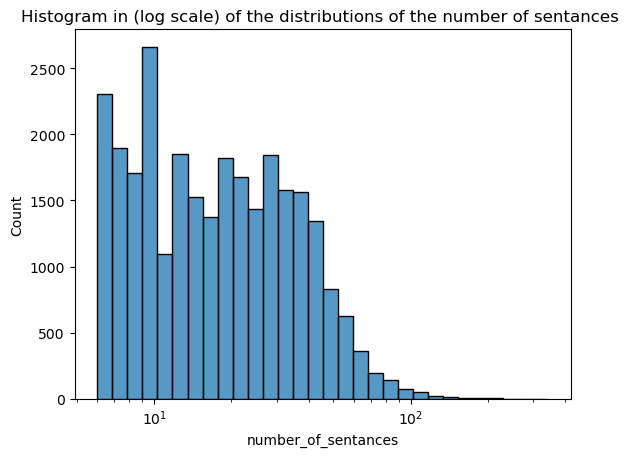

In [166]:
hist_plot = sns.histplot(data=processed_df, x = "number_of_sentances", log_scale=True,  bins=30)
hist_plot.set_title("Histogram in (log scale) of the distributions of the number of sentances ")

Let us visualize the distribution of the boxOffice present in the plot.

Text(0.5, 1.0, 'Histogram in (log scale) of the distributions of the Box Office Revenue')

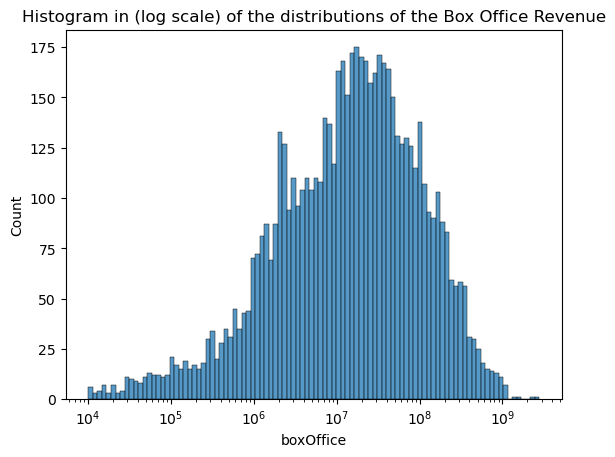

In [167]:
hist_plot = sns.histplot(data=processed_df, x = "boxOffice", log_scale=True, bins=100)
hist_plot.set_title("Histogram in (log scale) of the distributions of the Box Office Revenue")

Movies can be classified into various genres based on their shared themes, settings, characters, and story elements. Some popular genres include action, comedy, drama, horror, romance, and science fiction. These genres serve as helpful categorizations for films, allowing audiences and filmmakers to understand the type of content they can expect. For instance, a horror movie is likely to feature elements of suspense, fear, and tension. In this context, it would be useful to identify the most common genres present in the CMU dataset and use each genre as a separate dataset for analysis, as the emotional arc of a movie is often influenced by its genre.

In [168]:
def get_unique_elements(feature):
    # this function takes as input the feature column and return a list of all the unique elements in the list
    feature_vector = []
    for sample in feature:
        feature_vector.extend(json.loads(sample).values())

    return list(set(feature_vector))

# get the distinct genres present in the dataset
unique_genre_vector = get_unique_elements(processed_df["genres"].values)

# initialize a feature vector
feature = [0]*len(unique_genre_vector)

# increment the index that corresponds to the genre present
for sample_id, sample in processed_df.iterrows():
    list_of_features_present = list(json.loads(sample["genres"]).values())
    for feature_name in list_of_features_present:
        feature[unique_genre_vector.index(feature_name)]+=1

genres_dataframe = pd.DataFrame({"genres": unique_genre_vector, "count":feature})
genres_dataframe = genres_dataframe.sort_values(by="count", ascending=False)


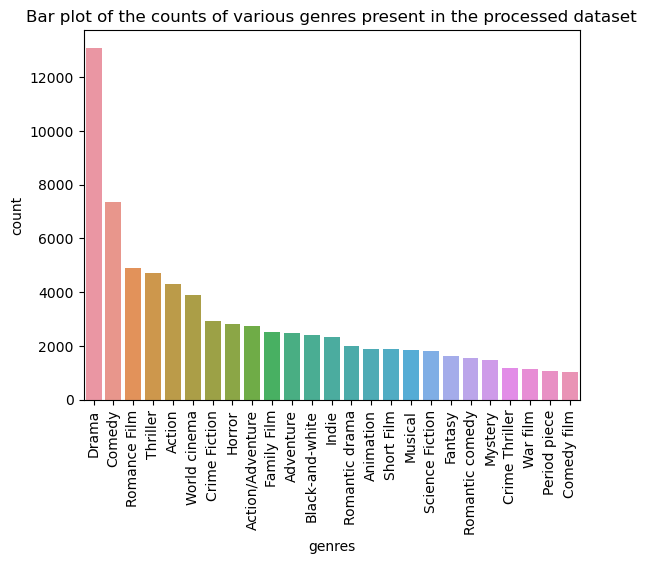

In [169]:
genres_dataframe = genres_dataframe[genres_dataframe["count"]>1000]

# barplots
barplot = sns.barplot(data=genres_dataframe, x="genres", y="count")
barplot.set_title("Bar plot of the counts of various genres present in the processed dataset")

plt.xticks(rotation=90)
plt.show()

Since movie emotional arcs can be heavily influenced by genre, it is important to consider this factor when analyzing the data. To do this, we can divide our dataset into separate dataframes for each genre of interest, ensuring that each dataframe contains only movies of that specific genre. However, it is common for movies to belong to multiple genres, so it is important to split the dataset in a mutually exclusive manner. This means that when we are constructing a dataframe for a specific genre, we should only include movies that do not belong to any other genre of interest.

In [170]:
genres_of_interest =  ["drama", "comedy", "thriller", "horror", "crime thriller", "action", "comedy film"]

# In this part, we create different dataframes for the most common genres (1. Drama, 2. Comedy, 3. Romance, 4. Action/Thriller)
def is_needed_genre(genre_movie: Dict[str, str],genres_to_match: str):
        
        # get list of genres present in the movie
        list_of_genres_in_movie = list(genre_movie.values())

        # get list of genres to discard to avoid duplicates
        genres_to_discard = [genre for genre in genres_of_interest if genre not in genres_to_match]
        
        # flags to be used
        contains_needed_genre = False
        contains_not_needed_genres = False
        
        # iterate over all genres present in the movies
        for genre in list_of_genres_in_movie:
            # check if there is a match
            
            if (genre.lower() in genres_to_match):
                contains_needed_genre = True
            
            if (genre.lower() in genres_to_discard):
                contains_not_needed_genres = True
 
        # return True only if meets the following criteria
        return (contains_needed_genre) and (not contains_not_needed_genres)

# construct the 4 different datasets 
processed_df["action"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["action", "thriller", "crime thriller"]))
processed_df["drama"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["drama"]))
processed_df["comedy"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["comedy", "comedy film"]))
processed_df["horror"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["horror"]))

In [171]:
# create the action dataframe
action_df = processed_df[processed_df["action"]].copy().drop(["action", "comedy", "drama", "horror"], axis=1)

# create the romance dataframe
horror_df = processed_df[processed_df["horror"]].copy().drop(["action", "comedy", "drama", "horror"], axis=1)

# create the drama dataframe
drama_df = processed_df[processed_df["drama"]].copy().drop(["action", "comedy", "drama", "horror"], axis=1)

# create the comedy dataframe
comedy_df = processed_df[processed_df["comedy"]].copy().drop(["action", "comedy", "drama", "horror"], axis=1)

In [172]:
# form the dataset loader
dataset_by_genre = {"Action": action_df.copy(), "Horror": horror_df.copy(), "Drama":drama_df.copy(), "Comedy":comedy_df.copy()}

In [173]:
# Let us visualize the size of the constructed dataset
print(f"The size of the action dataset is {len(action_df)}")
print(f"The size of the romance dataset is {len(horror_df)}")
print(f"The size of the drama dataset is {len(drama_df)}")
print(f"The size of the comedy dataset is {len(comedy_df)}")

The size of the action dataset is 2476
The size of the romance dataset is 1273
The size of the drama dataset is 7515
The size of the comedy dataset is 4605


With the separate dataframes for each genre, we can now visualize the emotional arc of a randomly chosen movie from each genre. 

Text(0.04, 0.5, 'Sentiment Value')

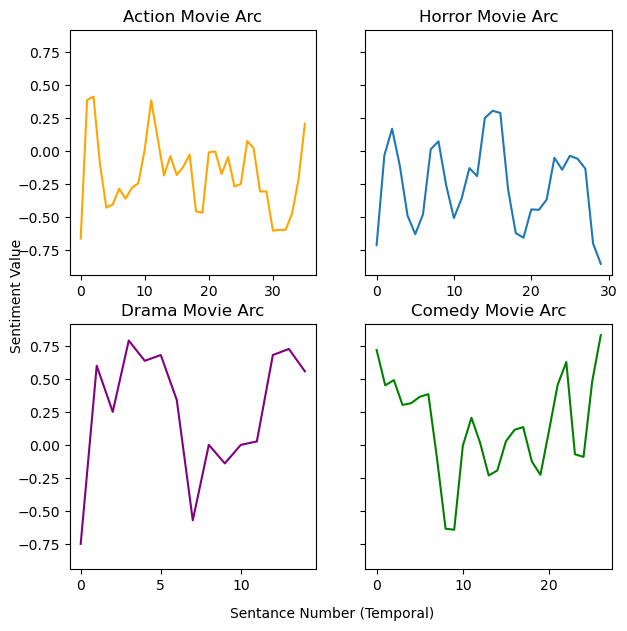

In [174]:
# now let us visualize different movie arcs for each genre (a sample from each)
fig, axis = plt.subplots(2,2, figsize=(7,7), sharey=True)
# plot the random movie arc
axis[0,0].plot(list(action_df.iloc[0]["plot_scores"]), color="orange")
axis[0,0].set_title("Action Movie Arc")

axis[0,1].plot(list(horror_df.iloc[10]["plot_scores"]))
axis[0,1].set_title("Horror Movie Arc")

axis[1,0].plot(list(drama_df.iloc[5]["plot_scores"]), color="purple")
axis[1,0].set_title("Drama Movie Arc")

axis[1,1].plot(list(comedy_df.iloc[10]["plot_scores"]), color="green")
axis[1,1].set_title("Comedy Movie Arc")

fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")


Visualizing the emotional arc of a single movie can be noisy and not representative of the overall trend. To get a more accurate picture of the typical emotional arc for a genre, it is helpful to compute the average sentiment scores for all the movies in the genre. However, this can be challenging due to the fact that movies have different lengths and the sentiment scores may be unevenly distributed over time.

One way to address this issue is to use the tslearn library, which contains tools for computing the typical (barycenter) of time series of different lengths. To compute the typical emotional arc for a genre, we can use tslearn to compute the barycenter of the sentiment scores for all the movies in the genre. This will give us a more accurate representation of the typical emotional arc for the genre, taking into account the fact that different movies have different lengths.

In [175]:
def form_features(series_frame: pd.Series):
    dictionary = series_frame.to_dict()
    list_values = [list(emotional_arc) for emotional_arc in dictionary.values() if len(list(emotional_arc))>2]
    return to_time_series_dataset(list_values)

def get_most_common_movie_arc_using_softdtw(series_frame):
    centers =  softdtw_barycenter(form_features(series_frame))  
    return centers

In [ ]:
# Averaging using tslearn library

# Visualize the most common movie arc in each genre (by taking average of all the datapoints in that genre)
typical_action_movie = get_most_common_movie_arc_using_softdtw(action_df["plot_scores"])

typical_horror_movie = get_most_common_movie_arc_using_softdtw(horror_df["plot_scores"])

typical_drama_movie = get_most_common_movie_arc_using_softdtw(drama_df["plot_scores"])

typical_comedy_movie = get_most_common_movie_arc_using_softdtw(comedy_df["plot_scores"])


Text(0.04, 0.5, 'Sentiment Value')

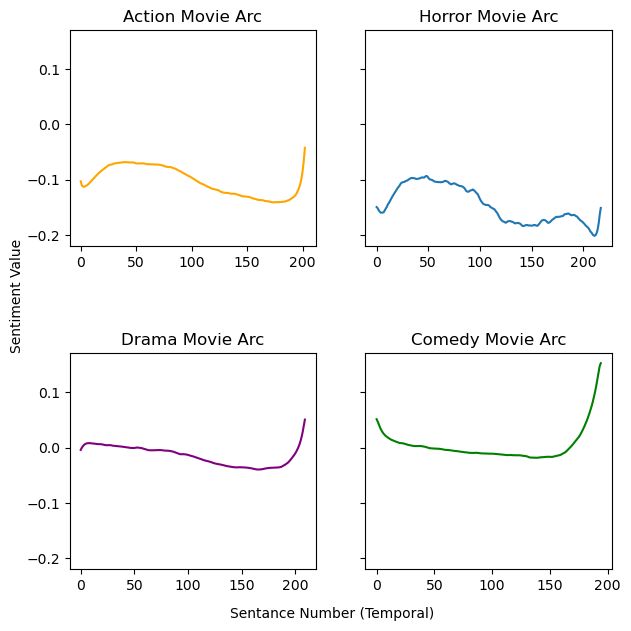

In [ ]:
fig, axis = plt.subplots(2,2, figsize=(7,7), sharey=True)
axis[0,0].plot(typical_action_movie, color="orange")
axis[0,0].set_title("Action Movie Arc")

axis[0,1].plot(typical_horror_movie)
axis[0,1].set_title("Horror Movie Arc")

axis[1,0].plot(typical_drama_movie, color="purple")
axis[1,0].set_title("Drama Movie Arc")

axis[1,1].plot(typical_comedy_movie, color="green")
axis[1,1].set_title("Comedy Movie Arc")


fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

#### Part 1.3: Clustering Analysis of the Story Arcs

To cluster the emotional arcs of movies by genre, we can use the tslearn library, which provides tools for clustering time series data. In our analysis, we will consider two different representations of the time series: (1) continuous values ranging from -1 to 1, and (2) discrete classes (-1, 0, and 1). We will use the Silhouette score as a metric to evaluate the quality of the clusters.

With that, we performed a grid search with the following combinations: <br>

-1- TimeSeries Kmeans, Soft Dynamic Time Wrapping (soft-dtw) as a metric, continuous features and varying the K value from 3 to 6. <br>
-2- TimeSeries Kmeans, Soft Dynamic Time Wrapping (soft-dtw) as a metric, discrete features and varying the K value from 3 to 6. <br>

After performing the grid search and evaluating the Silhouette scores for each combination, we can choose the combination that maximizes the score as the optimal solution for our analysis. We can then use this combination to cluster the emotional arcs of movies by genre and visualize the resulting clusters.

It is worth noting that the Kernal Kmeans algorithm, which is provided by the tslearn library, can be computationally intensive and may take a long time to run on large datasets. It takes around 8 hours to cluster 1 genre and hence accordingly it takes 128 hours to execute the analysis proposed. In our analysis, we found that the TimeSeries Kmeans algorithm with the soft-dtw distance metric provided similar results in a more efficient manner. We stored the results of our analysis in a pickle file in the generated folder for future reference (for both methods).


In [ ]:
# Clustering Analysis
def timeseries_kmeans(data, number_of_clusters):
    timeseries_kmeans = TimeSeriesKMeans(n_clusters=number_of_clusters, metric="softdtw")
    return timeseries_kmeans.fit_predict(form_features(data))


To analyze the profitability and ratings of different emotional story arcs, it is helpful to have access to information about the box office revenues of the movies. Therefore, it may be necessary to drop movies from the dataset that do not have this information available.

In [ ]:
cluster_analysis_dataloader = {}
for genre in list(dataset_by_genre.keys()):
    genre_dataframe = dataset_by_genre[genre].dropna(subset=["boxOffice"])
    cluster_analysis_dataloader[genre] = genre_dataframe

In [ ]:
for genre in cluster_analysis_dataloader.keys():
    print(f"The size of the {genre} Movies dataset after the processing step is {len(cluster_analysis_dataloader[genre])}")

The size of the Action Movies dataset after the processing step is 634
The size of the Horror Movies dataset after the processing step is 177
The size of the Drama Movies dataset after the processing step is 1396
The size of the Comedy Movies dataset after the processing step is 1184


To find the optimal feature to cluster on and the optimal number of clusters, we can run Timeseries Kmeans clustering on both features while repeating the clustering for diffrent number of clusters.

In [176]:
read_data_from_pickle = True

if not read_data_from_pickle:
    # use features
    clustering_label = {"Action": {"continuous_labels": [], "discrete_labels":[]}, 
                                            "Drama": {"continuous_labels": [], "discrete_labels":[] },
                                            "Comedy": {"continuous_labels": [], "discrete_labels":[]},
                                            "Horror": {"continuous_labels": [], "discrete_labels":[]}}

    # perform clustering
    for number_of_clusters in range(3,7):
        for genre in cluster_analysis_dataloader.keys():
            # genre dataframe
            genre_dataframe = cluster_analysis_dataloader[genre]

            # continuous features
            clustering_label[genre]["continuous_labels"].append(timeseries_kmeans(genre_dataframe["plot_scores"], number_of_clusters))

            # discrete features
            clustering_label[genre]["discrete_labels"].append(timeseries_kmeans(genre_dataframe["plot_classification"], number_of_clusters))
else:
    with open('generated/clustering_results.pickle', 'rb') as handle:
        clustering_label = pickle.load(handle)

To evaluate the quality of the clusters produced by Timeseries Kmeans clustering, we can use the Silhouette score as a metric. The Silhouette score measures how well-separated the clusters are and how similar the points within a cluster are. A high Silhouette score indicates that the clusters are well-defined and the points within a cluster are similar, while a low Silhouette score indicates that the clusters are poorly defined or that the points within a cluster are dissimilar.

In [177]:
if not read_data_from_pickle:
    clustering_silhouette_score = {"Action": [],"Drama":[], "Comedy": [], "Horror": []}
    for genre in clustering_label.keys():
        for number_of_clusters in range(3,7):
            clustering_silhouette_score[genre].append(silhouette_score(cluster_analysis_dataloader[genre]["plot_scores"].values, clustering_label[genre]["continuous_labels"][number_of_clusters-3], "softdtw"))
else:
    with open('generated/clustering_silhouette_score.pickle', 'rb') as handle:
        clustering_silhouette_score = pickle.load(handle) 

In [178]:
if not read_data_from_pickle:
    discrete_clustering_silhouette_score = {"Action": [],"Drama":[], "Comedy": [], "Horror": []}
    for genre in clustering_label.keys():
        for number_of_clusters in range(3,7):
            discrete_clustering_silhouette_score[genre].append(silhouette_score(cluster_analysis_dataloader[genre]["plot_classification"].values, clustering_label[genre]["discrete_labels"][number_of_clusters-3], "softdtw"))
else:
    with open('generated/discrete_clustering_silhouette_score.pickle', 'rb') as handle:
        discrete_clustering_silhouette_score = pickle.load(handle) 

In order to visualize the Silhouette score results for the different number of clusters and different features, we plot them below, 

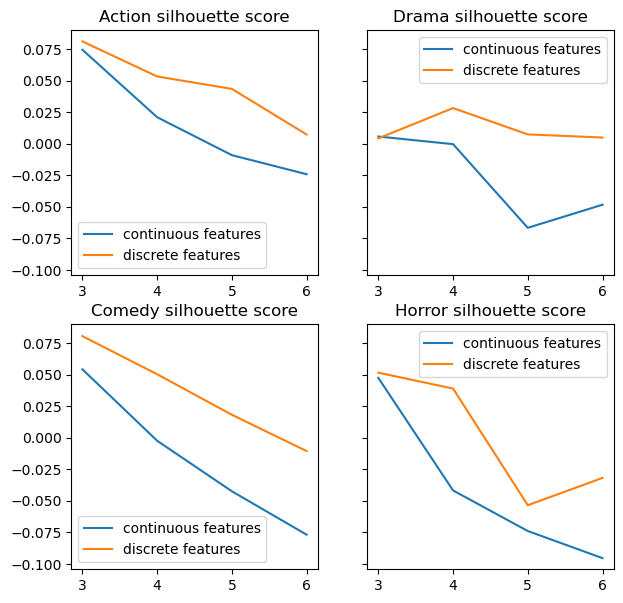

In [179]:
# plot the silhouette score
fig, axis = plt.subplots(2,2, figsize=(7,7), sharey=True)

# X_values
x_values = np.arange(3,7)

for index, genre in enumerate(clustering_silhouette_score.keys()):
    # Clustering Silhoutte scores
    axis[int(index/2),int(index%2)].plot(x_values, clustering_silhouette_score[genre], label = "continuous features")
    axis[int(index/2),int(index%2)].plot(x_values, discrete_clustering_silhouette_score[genre], label = "discrete features")
    axis[int(index/2),int(index%2)].legend()
    axis[int(index/2),int(index%2)].set_title(f"{genre} silhouette score")


In [180]:
best_sils = {k: max(np.max(discrete_clustering_silhouette_score[k]),np.max(clustering_silhouette_score[k])) for k in discrete_clustering_silhouette_score.keys()}
print(best_sils)

{'Action': 0.08101022416193251, 'Drama': 0.028233651729237513, 'Comedy': 0.0804257758127642, 'Horror': 0.051524570044808614}


In [181]:
best_ks = {k: discrete_clustering_silhouette_score[k].index(v) + 3 if v in discrete_clustering_silhouette_score[k] else clustering_silhouette_score[k].index(v) + 3 for k,v in best_sils.items()}
print(best_ks)

{'Action': 3, 'Drama': 4, 'Comedy': 3, 'Horror': 3}


In [182]:
best_labels = {k: clustering_label[k]["discrete_labels"][best_ks[k]-3] if v in discrete_clustering_silhouette_score[k] else clustering_label[k]["continuous_labels"][best_ks[k]-3] for k,v in best_sils.items()}

In [183]:
for genre in cluster_analysis_dataloader.keys():
    cluster_analysis_dataloader[genre]["cluster_id"] = best_labels[genre]

In [184]:
name_cluster = ['cluster_' + str(i) for i in (np.array(range(best_ks['Action']))+1)]
name_cluster

['cluster_1', 'cluster_2', 'cluster_3']

Text(0.0, 0.5, 'Number of Movies')

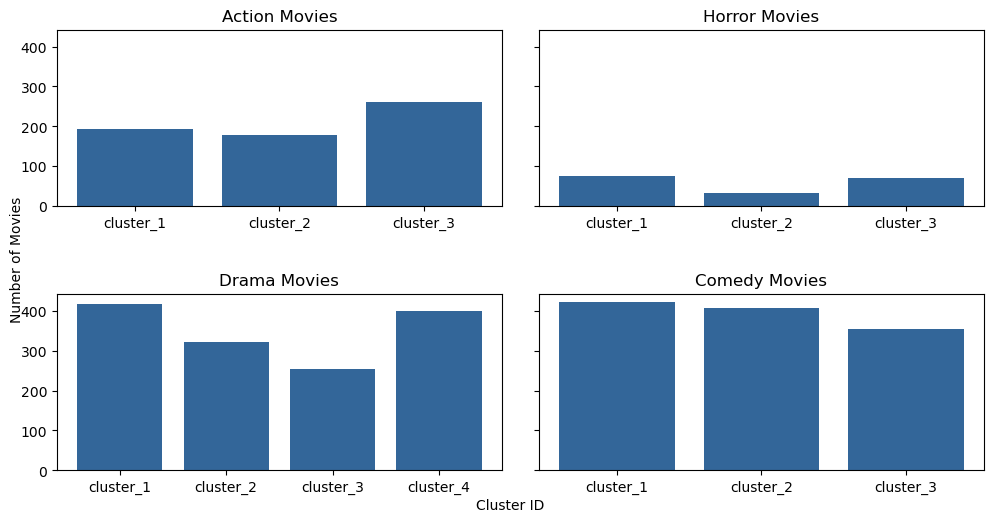

In [185]:
fig, axis = plt.subplots(2,2, figsize=(10,5), sharey=True)
fig.tight_layout() 

# visualize the distribution of the various sentiments using bar plots
for index, genre in enumerate(cluster_analysis_dataloader.keys()):
    head =  cluster_analysis_dataloader[genre]['cluster_id'].value_counts().loc[range(best_ks[genre])]
    axis[int(index/2),index%2].bar(['cluster_' + str(i) for i in (np.array(range(best_ks[genre]))+1)], head.values, color=(0.2, 0.4, 0.6))
    axis[int(index/2),index%2].set_title(f"{genre} Movies")
    
fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.00, "Cluster ID", ha="center")
fig.text(0.0, 0.5, "Number of Movies", va="center", rotation="vertical")

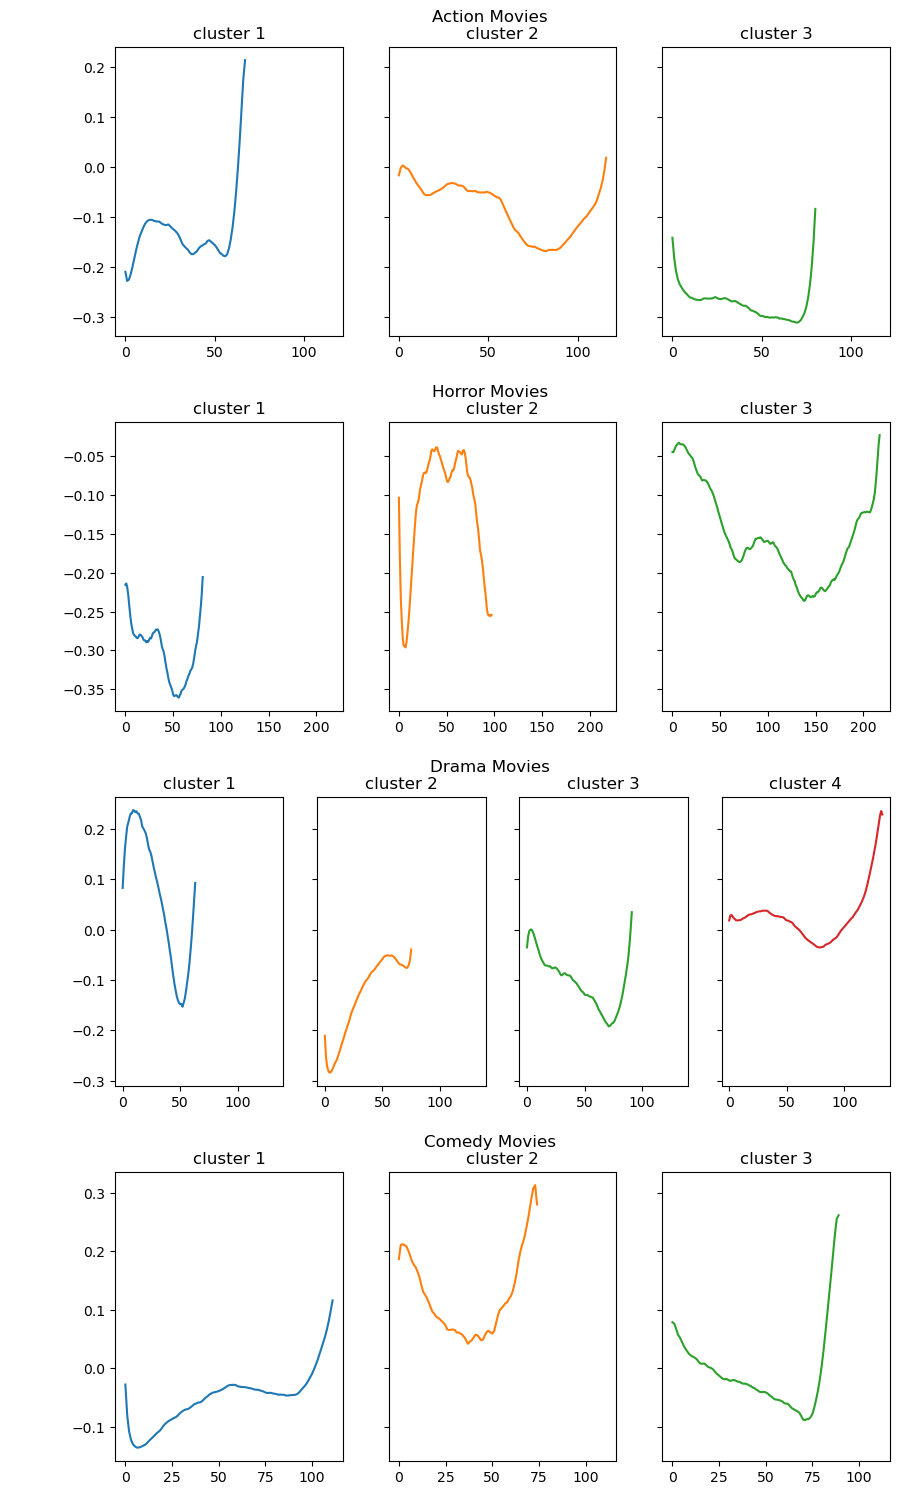

In [186]:
fig = plt.figure(figsize = (10,15))
subfigs = fig.subfigures(nrows=4, ncols=1)


for index, jointed_genres in enumerate(zip(cluster_analysis_dataloader.keys(), subfigs)):
    jointed_genres[1].suptitle(f"{jointed_genres[0]} Movies")
    groued_dataset = cluster_analysis_dataloader[jointed_genres[0]].groupby("cluster_id")
    colors = plt.rcParams["axes.prop_cycle"]()

    # create 1x3 subplots per subfig
    axs = jointed_genres[1].subplots(nrows=1, ncols=best_ks[jointed_genres[0]], sharex=True, sharey=True)
    for key in groued_dataset.groups.keys():

        # get color
        c = next(colors)["color"]
        common_featurs= get_most_common_movie_arc_using_softdtw(groued_dataset.get_group(key)["plot_scores"])

        # filter value
        axs[key].plot(common_featurs, color=c)
        axs[key].set_title(f"cluster {key + 1}")

# common axis label
fig.supxlabel('Sentance Number')
fig.supylabel('Sentiment Value')
fig.subplots_adjust(hspace=0.5)

To conclude on this part, we were able to construct a data processing pipeline that will allow us to analyze the sentiment of the movies and the various story arcs present in each genre. 

### Part 2: From the provided dataset to our sicentific question

We'd want to examine and answer multiple scientific questions now that we've studied and visualized the CMU Corpus dataset. These are the questions:

* What is the effect of the presence of emotions on the success of the movie, do emotional movies have a higher IMDB rating? Does the effect differ between genres?

* What is the effect of the positive/negative emotions on the success of the movie, do movies that are predominently positive (more than 50% of the lines are positive) have a higher IMDB rating? or is the opposite effect true? and do the observed effect vary per genre? 

* What is the most profitable movie arc per genre, is their a clear winner among the various clusters?

* What is the most rated movie arc per genre, is their a clear winner among the various clusters?

* Does the most typical movie arc change over time? If so, what are the various movie arcs that take place in various time periods, and what are their profitability and rating?

In order to answer the above posed questions, we need to construct the needed dataframes before running any statstical tests to answer our questions. In this section, we will construct the various needed datasets and we will perform the extensive analysis to answer the above questions.

Accordingly, based on the questions posed, we can see that we divide the pre-processing step into two parts; movie sentiment dataframe construction, ratings and box office revenue dataframe construction.

#### Sentiment pre-processing and Movie plot classification

To classify movies based on sentiment and type, we follow these steps:

Movie Sentiment:

* We count the number of lines classified as negative, neutral, and positive.
* If the number of lines in a certain class is more than half the total number of lines, the movie is classified as corresponding to that class.

Movie Type:

* Based on the Movie Sentiment classification, if the movie is classified as positive or negative, it is considered an emotional movie. If it is classified as neutral, it is considered non-emotional.


In [187]:
# for each genre, get the negative score, neutral score and positive score
for dataset in dataset_by_genre.values():
    # get the negative scores
    dataset["negative_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == -1))

    # get the neutral scores
    dataset["neutral_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == 0))

    # get the positive scores
    dataset["positive_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == 1))

    # movie emotion score
    dataset["emotion_score"] = dataset["plot_scores"].apply(lambda x: np.mean(x))

# visualize one the dataframe
dataset_by_genre['Action'].head(3)


,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,language,Runtime,negative_score,neutral_score,positive_score,emotion_score
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333452, 0.3856095238095195, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,"{""/m/02h40lc"": ""English Language""}",110.0,20,6,10,-0.181695
7,11250635,The story starts as one of the robots flies i...,NaN,The Mechanical Monsters,NaN,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, -1, 1, 1, -1, -...","[-0.0025414285714287746, 0.010165714285714281,...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",26,"{""/m/02h40lc"": ""English Language""}",NaN,9,7,10,0.043239
14,9633533,"Professor Kurian Fernandez , a convict escapes...",1989,Vandanam,NaN,"[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.07068714285714348, -0.2813485714285723, -0....","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",33,"{""/m/0999q"": ""Malayalam Language""}",168.0,14,8,11,-0.065971


In [189]:
# for each genre, classify the plot as neutral, negative and positive

# Classify if the movie is an emotional movie or not
def classify_emotional(sentiment):
    if(sentiment == "neutral_movie"):
        return 'non_emotional'
    elif sentiment in ["negative_movie", "positive_movie"]:
        return 'emotional'

for dataset in dataset_by_genre.values():
    # classify 
    dataset.loc[(dataset["neutral_score"]>=0.5*dataset["number_of_sentances"]), "movie_sentiment"] = 'neutral_movie'
    dataset.loc[(dataset["negative_score"]>=0.5*dataset["number_of_sentances"]),"movie_sentiment"] = 'negative_movie'
    dataset.loc[(dataset["positive_score"]>=0.5*dataset["number_of_sentances"]),"movie_sentiment"] = 'positive_movie'
    dataset['movie_type'] = dataset['movie_sentiment'].apply(lambda s : classify_emotional(s))

    # we drop all movies that are not classified
    dataset.dropna(subset=["movie_type"], inplace=True)

# visualize one dataframe (Action Dataframe)
dataset_by_genre['Action'].head(5)

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,language,Runtime,negative_score,neutral_score,positive_score,emotion_score,movie_sentiment,movie_type
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333452, 0.3856095238095195, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,"{""/m/02h40lc"": ""English Language""}",110.0,20,6,10,-0.181695,negative_movie,emotional
24,4951456,A Japanese businessman sees a woman being grop...,1989,Kinjite: Forbidden Subjects,3416846.0,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",14,"{""/m/02h40lc"": ""English Language""}",97.0,5,7,2,-0.218286,neutral_movie,non_emotional
208,24282238,Yamraaj is the story of two thieves Birju and...,1998-07-31,Yamraaj,NaN,"[1, -1, 1, -1, -1, 1]","[0.0516, -0.0516, 0.1154, -0.3182, -0.3612, 0....","{""/m/03rk0"": ""India""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02kdv5l"": ""A...",6,"{""/m/03k50"": ""Hindi Language""}",NaN,3,0,3,-0.020600,positive_movie,emotional
269,9678161,"The film deals with student strength. Shiva , ...",1996,Maanbumigu Maanavan,NaN,"[1, 1, 1, -1, 1, -1, 1, -1]","[0.4939, 0.9623, 0.4767, -0.8126, 0.2023, -0.8...","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",8,"{""/m/07c9s"": ""Tamil Language""}",139.0,3,0,5,0.044562,positive_movie,emotional
296,1378672,Michael Lynch is one of Dublin's most notoriou...,2000,Ordinary Decent Criminal,NaN,"[-1, 1, 0, 1, -1, 1, 1, 1, -1, 0]","[-0.8004, 0.2732, 0.0, 0.4168, -0.5423, 0.6597...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",10,"{""/m/02h40lc"": ""English Language""}",93.0,3,2,5,0.045700,positive_movie,emotional


Having classified the movie plots as emotional or non-emotional, we can now visualize the distribution of movie types within each genre.

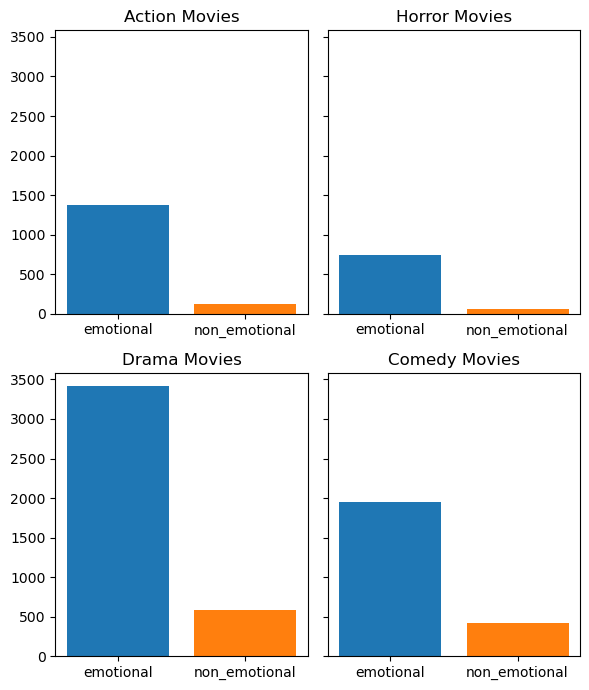

In [190]:
fig, axs = plt.subplots(2,2,figsize=(6, 7), sharey=True)
for index, dataset in enumerate(list(dataset_by_genre.keys())):  
    head =  dataset_by_genre[dataset]['movie_type'].value_counts().loc[["emotional", "non_emotional"]]
    axs[int(index/2),index%2].bar(head.index, head.values, color=["tab:blue", "tab:orange"])  
    axs[int(index/2),index%2].set_title(dataset + " Movies")
    axs[int(index/2),index%2].set(xlabel=None)
fig.tight_layout()

As can be seen from the above figure, the emotional movies are more predimonent compared to non-emotional movies in all genres. 

With that given, we can also visualize the distribution of negative, neutral and positive sentiments in all genres.

Text(0.0, 0.5, 'Number of Movies')

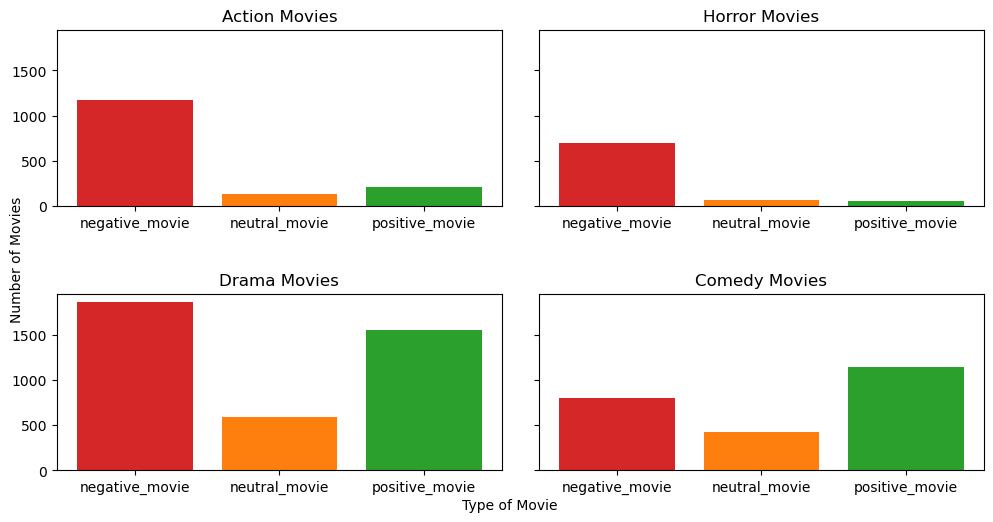

In [191]:
fig, axis = plt.subplots(2,2, figsize=(10,5), sharey=True)
fig.tight_layout() 

# visualize the distribution of the various sentiments using bar plots
for index, dataset in enumerate(dataset_by_genre.keys()):
    head =  dataset_by_genre[dataset]['movie_sentiment'].value_counts().loc[["negative_movie", "neutral_movie", "positive_movie"]]
    axis[int(index/2),index%2].bar(head.index, head.values, color=["tab:red", "tab:orange", "tab:green"])
    axis[int(index/2),index%2].set_title(f"{dataset} Movies")
    
fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.00, "Type of Movie", ha="center")
fig.text(0.0, 0.5, "Number of Movies", va="center", rotation="vertical")

As we can see from the above bar plot: <br>

* Negative Movies are more prevalent in Action, Drama and horror genres. <br>
* Positive Movies are more present in Comedy Movies. <br>
* Neutral Movies are the least prevalent in all the studied genres. <br>

Based on these findings, it seems that the skewed distribution of movie counts in each genre may be due to the success of movies in terms of ratings and profitability. It is possible that positive movies are more successful in the comedy genre, while the opposite may be true for drama, horror, and action movies. Do positive movies tend to do better in the comedy category compared to negative movies, while negative movies may perform better in the drama, horror, and action genres? <br>

We will perform a matched observational study (to deal with hidden confounds) to provide a possible explanation.  


#### Introducing and pre-processing the IMDB ratings

In our analysis, we used two datasets to measure the success of a movie: the CMU Movie Metadata dataset, which provided profitability data, and the IMDB dataset, which provided ratings. We joined these datasets using the original title of the movie as a key. In cases where there were multiple versions of the same movie in different languages, we calculated the average weighted sum of the ratings for all the versions to get the overall rating of the movie in the CMU Movie dataset.

In [194]:
#load the movie title dataset
df_name_basics = pd.read_csv('IMDB/titles.tsv', sep = '\t', low_memory =False)

In [195]:
#load the movie rating dataset
df_ratings = pd.read_csv('IMDB/ratings.tsv', sep = '\t')

In [196]:
# only choose the rows which correspond to a data of a movie
df_title = df_name_basics[df_name_basics['titleType'] == 'movie']

In [197]:
#merge the dataset with the titles and the dataset with the ratings
df_imdb = df_title.merge(df_ratings, left_on='tconst', right_on='tconst')

In [198]:
#create datasets of average ratings of a movie considering the ratings of movies with titles in different language

# get the the IMDB dataset and specifically utilize (1) original title (2) average rating (3) number of votes (4) primary title
df_imdb= df_imdb[['originalTitle', 'averageRating', 'numVotes', 'primaryTitle']] #contains all ratings for every movie
df_imdb['multiplication'] = df_imdb['averageRating']*df_imdb['numVotes']


grouped = pd.DataFrame()
grouped['sum_of_mult'] = df_imdb[['originalTitle', 'multiplication']].groupby('originalTitle').sum()
grouped['sum_of_vote'] = df_imdb[['originalTitle', 'numVotes']].groupby('originalTitle').sum()
grouped['average_rating'] = grouped['sum_of_mult']/grouped['sum_of_vote']

grouped = grouped.reset_index(level=0)
grouped.drop(['sum_of_mult'], axis =1).head()

ratings_genre_df = {"Action": pd.DataFrame(), "horror": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}

#average ratings for every genre
for dataset in dataset_by_genre.keys():
    ratings_genre_df[dataset] = grouped.merge(dataset_by_genre[dataset], left_on = 'originalTitle', right_on = 'Title')


In [199]:
ratings_genre_df["Action"].head(3)

,originalTitle,sum_of_mult,sum_of_vote,average_rating,id,plot,release date,Title,boxOffice,plot_classification,...,genres,number_of_sentances,language,Runtime,negative_score,neutral_score,positive_score,emotion_score,movie_sentiment,movie_type
0,10 to Midnight,53090.1,8427,6.300000,14979283,10 to Midnight is a drama that mixes elements ...,1983,10 to Midnight,7175592.0,"[0, -1, -1, -1, -1, -1, -1, 0, -1, 0]",...,"{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",10,"{""/m/02h40lc"": ""English Language""}",103.0,7,3,0,-0.355770,negative_movie,emotional
1,12 Rounds,164286.2,29327,5.601875,15169291,A sting operation to capture notorious arms de...,2009-03-19,12 Rounds,18184083.0,"[-1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1, -1,...",...,"{""/m/0cq22f9"": ""Action Thrillers"", ""/m/01jfsb""...",105,"{""/m/02h40lc"": ""English Language""}",108.0,33,53,19,-0.087764,neutral_movie,non_emotional
2,143,5511.2,655,8.414046,34191227,Siddu is a carefree boy-next-door. Sanjana i...,2004-08-27,143,NaN,"[1, 0, 1, 1, 0, 0, 0, -1, -1, 0]",...,"{""/m/01jfsb"": ""Thriller"", ""/m/02l7c8"": ""Romanc...",10,"{""/m/09s02"": ""Telugu language""}",143.0,2,5,3,0.002080,neutral_movie,non_emotional


#### Part 2.1: Emotional vs Non-emotional movies (ratings)

In [200]:
processed_ratings_emotional_df={}

# classify the movie and compute the average rating of the emotional movie and of the non emotional movie
for index, genre in enumerate(dataset_by_genre.keys()):
    # merge the current dataframe with the ratings dataframe
    processed_ratings_emotional_df[genre] = dataset_by_genre[genre][['id', 'movie_type', 'release date', 'country', 'genres', 'Runtime', 'language', 'emotion_score', 'movie_sentiment', 'boxOffice']].merge(ratings_genre_df[genre][['id', 'average_rating', 'sum_of_vote']], left_on='id', right_on='id')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    processed_ratings_emotional_df[genre] = processed_ratings_emotional_df[genre][processed_ratings_emotional_df[genre]['sum_of_vote'] >= 100]
    processed_ratings_emotional_df[genre].reset_index(inplace=True)

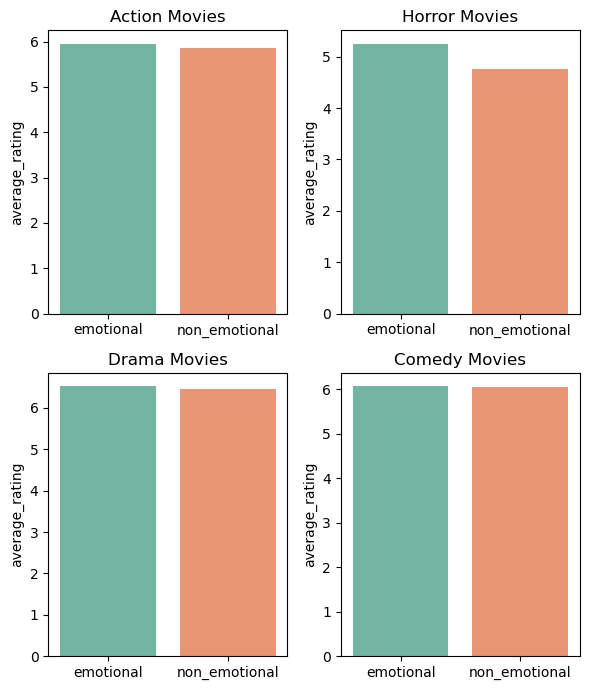

In [201]:
fig, axs = plt.subplots(2,2,figsize=(6, 7))
for index, dataset in enumerate(processed_ratings_emotional_df.keys()):  
    # average ratings per group
    mean_ratings_movie_type = processed_ratings_emotional_df[dataset].copy().groupby('movie_type').mean()
    mean_ratings_movie_type.reset_index(inplace=True)
    
    # sns barplot displaying the average rating per movie type (emotional vs non-emotional)
    sns.barplot(x="movie_type", y="average_rating", data=mean_ratings_movie_type, ax=axs[int(index/2),index%2], palette="Set2")
    axs[int(index/2),index%2].set_title(dataset + " Movies")
    axs[int(index/2),index%2].set(xlabel=None)
fig.tight_layout()

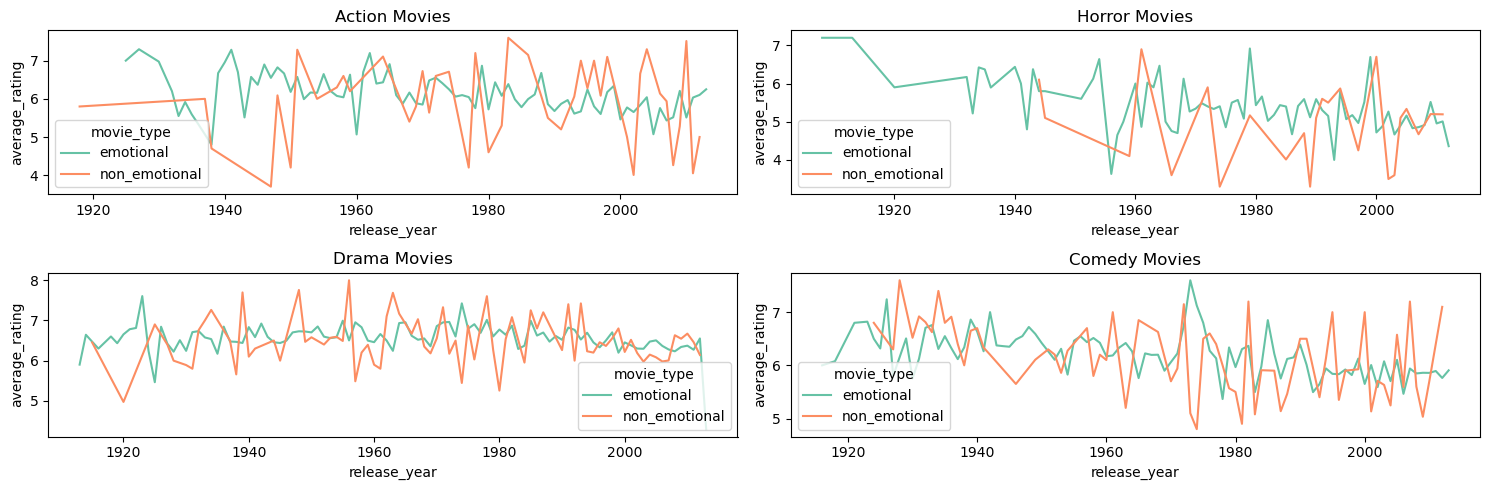

In [202]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_type', 'release_year']).mean()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="average_rating", data=mean_box_cluster, hue="movie_type",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()


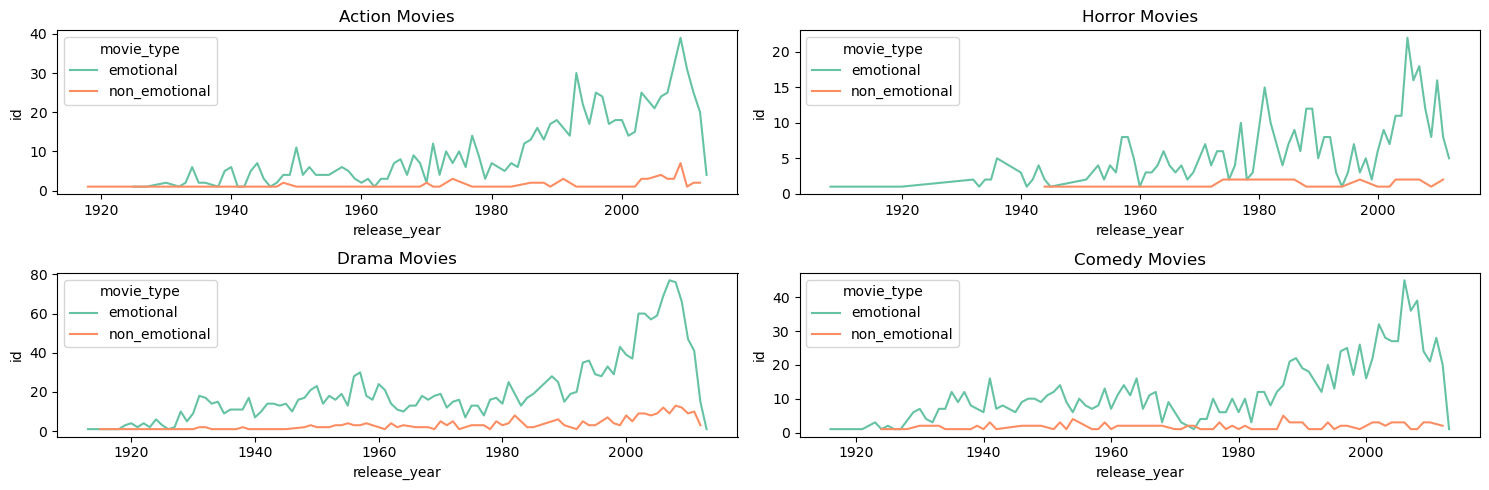

In [203]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_type', 'release_year']).count()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="id", data=mean_box_cluster, hue="movie_type",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()

Now that we have classified the movies into emotional/non-emotional, we can now performed a matched study (since our data is collected from observation; real-world data). The matched study consists of matching each movie that is emotional with a movie that is not-emotional based on similar runtime and emotion score. This can remove certain confounds that can affect both (1) the success of the movie and (2) the movie being emotional or not.

In [204]:
emotional_dataset = {}
non_emotional_dataset = {}

for genre in list(processed_ratings_emotional_df.keys()):
    dataset = processed_ratings_emotional_df[genre]
    emotional_dataset[genre] = dataset[dataset["movie_type"]=="emotional"]
    non_emotional_dataset[genre] = dataset[dataset["movie_type"]=="non_emotional"]
    print(f"The size of the emotional dataset of {genre} movies is of {len(emotional_dataset[genre])}")
    print(f"The size of the un-emotional dataset of {genre} movies is of {len(non_emotional_dataset[genre])}\n")

The size of the emotional dataset of Action movies is of 880
The size of the un-emotional dataset of Action movies is of 72

The size of the emotional dataset of Horror movies is of 450
The size of the un-emotional dataset of Horror movies is of 35

The size of the emotional dataset of Drama movies is of 2053
The size of the un-emotional dataset of Drama movies is of 295

The size of the emotional dataset of Comedy movies is of 1129
The size of the un-emotional dataset of Comedy movies is of 126



In [205]:
# list of ids to be used to track the matches
matched_emotional_ids = defaultdict(lambda: [])
matched_non_emotional_ids = defaultdict(lambda: [])

# iterate over all genres 
for genre in emotional_dataset.keys():
    for emotional_id, emotional_dataframe in emotional_dataset[genre].iterrows():
        for non_emotional_id, non_emotional_dataframe in non_emotional_dataset[genre].iterrows():
            if abs(emotional_dataframe["Runtime"] - non_emotional_dataframe["Runtime"])<20 and (abs(emotional_dataframe["emotion_score"] - non_emotional_dataframe["emotion_score"]))>0.05 and non_emotional_id not in matched_non_emotional_ids[genre]:
                matched_emotional_ids[genre].append(int(emotional_id))
                matched_non_emotional_ids[genre].append(int(non_emotional_id))
                break

In [206]:
matched_dataset_per_genre = {}
for genre in list(non_emotional_dataset.keys()):
    # concatenate the two dataframes (by correctly choosing the matched rows) and for the correct genres
    matched_dataset_per_genre[genre] = pd.concat([processed_ratings_emotional_df[genre].iloc[matched_non_emotional_ids[genre]], processed_ratings_emotional_df[genre].iloc[matched_emotional_ids[genre]]])

In [207]:
for genre in matched_dataset_per_genre.keys():
    print(f"The length of matched candidates in {genre} Movies is {int(len(matched_dataset_per_genre[genre])/2)}")


The length of matched candidates in Action Movies is 62
The length of matched candidates in Horror Movies is 33
The length of matched candidates in Drama Movies is 267
The length of matched candidates in Comedy Movies is 113


In [208]:
nbr_of_samples = 10000

# construct a N samples of size N 
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        # sample a dataset of sie N
        indices = np.random.randint(0, len(data), len(data))

        # form the dataset
        data_tmp = data[indices] 
        
        # compute the arithmetic mean
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)], np.mean(means)

In [209]:
emotional_movies_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Horror" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

non_emotional_movie_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Horror" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

pvalues_difference = {"Action" : 0, "Horror" : 0, "Drama" : 0, "Comedy" : 0}

for genre in matched_dataset_per_genre.keys():
    # get the genre matched dataframe
    genre_dataframe = matched_dataset_per_genre[genre]

    # get the emotional movies of that genre
    emotional_data = genre_dataframe[genre_dataframe["movie_type"] == "emotional"]

    # get the non emotional movies of that genre
    non_emotional_data= genre_dataframe[genre_dataframe["movie_type"] == "non_emotional"]

    # emotional metrics
    emotional_movies_metrics[genre]["Confidence Interval"], emotional_movies_metrics[genre]["Mean"] = bootstrap_CI(emotional_data["average_rating"].values, nbr_of_samples)
    
    # non emotional metrics
    non_emotional_movie_metrics[genre]["Confidence Interval"], non_emotional_movie_metrics[genre]["Mean"] = bootstrap_CI(non_emotional_data["average_rating"].values, nbr_of_samples)
    
    # pvalues of the independant t-test
    pvalues_difference[genre] = stats.ttest_ind(emotional_data["average_rating"] , non_emotional_data["average_rating"]).pvalue

In [210]:
for genre in emotional_movies_metrics.keys() :
    print(f"In {genre} movies")
    print(f"\tThe average rating for emotional movies is {emotional_movies_metrics[genre]['Mean']} and with the confidence {emotional_movies_metrics[genre]['Confidence Interval']}")

    print(f"\tThe average rating for non-emotional movies is {non_emotional_movie_metrics[genre]['Mean']} and with the confidence {non_emotional_movie_metrics[genre]['Confidence Interval']}")

    print(f"\tThe pvalues for the non emotional and emotional movies is {pvalues_difference[genre]}\n")

In Action movies
	The average rating for emotional movies is 6.080798988370424 and with the confidence [5.811068835797063, 6.341205285012771]
	The average rating for non-emotional movies is 5.772217725609645 and with the confidence [5.479175025795992, 6.056995281476109]
	The pvalues for the non emotional and emotional movies is 0.12979974917100215

In Horror movies
	The average rating for emotional movies is 5.1833874987831585 and with the confidence [4.873071315514167, 5.487332240241372]
	The average rating for non-emotional movies is 4.792743710073548 and with the confidence [4.392391517839868, 5.184176464230512]
	The pvalues for the non emotional and emotional movies is 0.1328470678239802

In Drama movies
	The average rating for emotional movies is 6.551734589555699 and with the confidence [6.437695351278005, 6.66247431695784]
	The average rating for non-emotional movies is 6.457782944662086 and with the confidence [6.340328438944258, 6.570221124894901]
	The pvalues for the non emot

#### Part 2.2: Positive vs Negative movies (ratings)

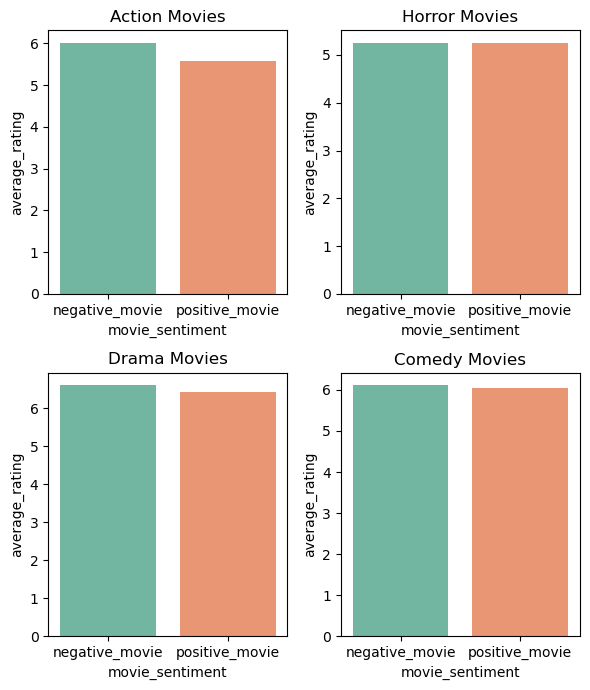

In [211]:
ratings_pn_df = dataset_by_genre.copy()
fig, axs = plt.subplots(2,2,figsize=(6, 7))

# filter the movie, we take only negative and positive movies and compute the average rating
for index, dataset in enumerate(ratings_pn_df.keys()):

    #filter the movie
    ratings_pn_df[dataset] = ratings_pn_df[dataset][(ratings_pn_df[dataset]['movie_sentiment'] == "negative_movie") | (ratings_pn_df[dataset]['movie_sentiment'] == "positive_movie")]
    ratings_pn_df[dataset] = ratings_pn_df[dataset][['id', 'movie_sentiment']].merge(ratings_genre_df[dataset][['id', 'average_rating', 'sum_of_vote']], left_on='id', right_on='id')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    ratings_pn_df[dataset] = ratings_pn_df[dataset][ratings_pn_df[dataset]['sum_of_vote'] >= 100][['movie_sentiment', 'average_rating']]
    mean_ratings_pn = ratings_pn_df[dataset].copy().groupby('movie_sentiment').mean()
    mean_ratings_pn.reset_index(inplace=True)
    sns.barplot(x="movie_sentiment", y="average_rating", data=mean_ratings_pn, ax=axs[int(index/2),index%2], palette="Set2")
    axs[int(index/2),index%2].set_title(dataset + " Movies")

fig.tight_layout()

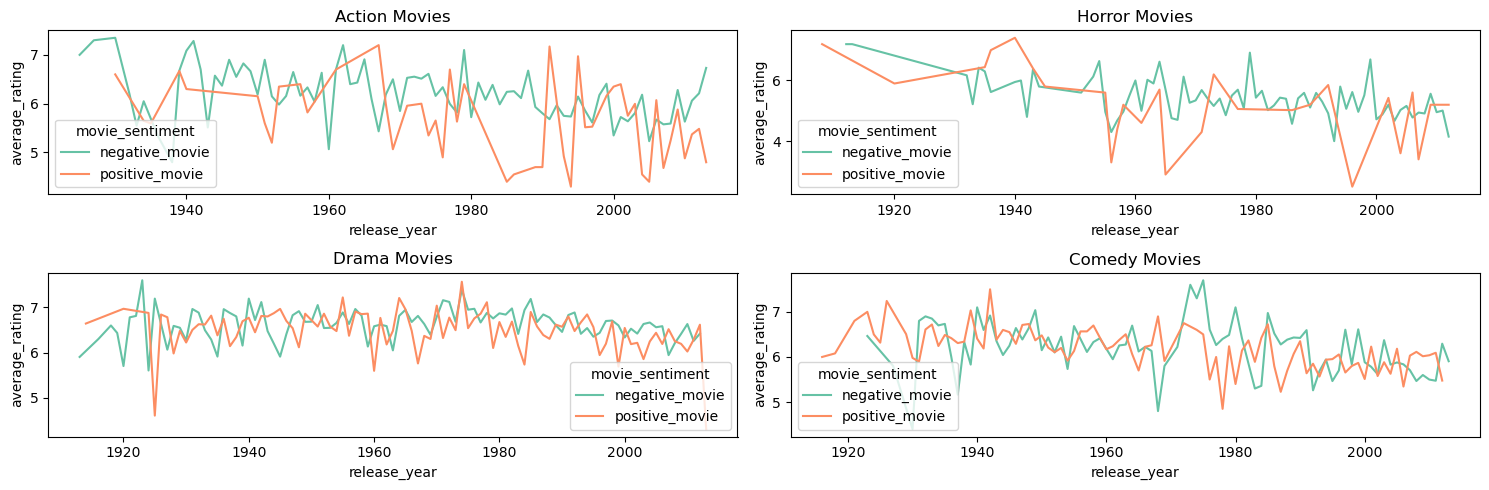

In [212]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe = genre_dataframe[genre_dataframe["movie_sentiment"].str.contains("neutral_movie") == False]
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_sentiment', 'release_year']).mean()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="average_rating", data=mean_box_cluster, hue="movie_sentiment",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()

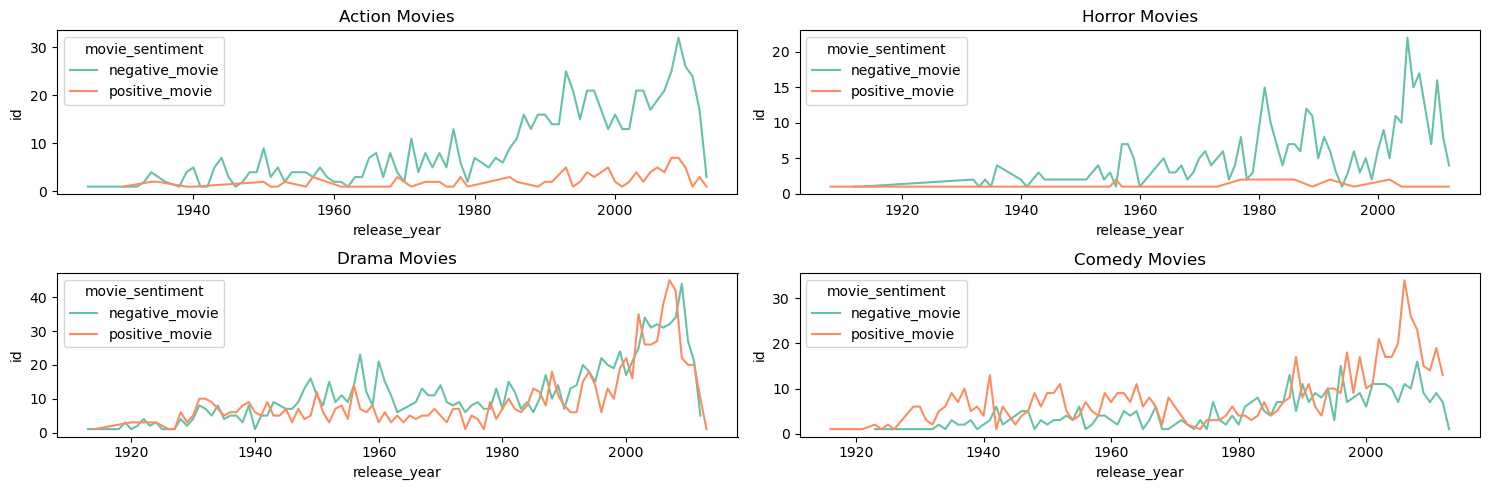

In [213]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe = genre_dataframe[genre_dataframe["movie_sentiment"].str.contains("neutral_movie") == False]
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_sentiment', 'release_year']).count()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="id", data=mean_box_cluster, hue="movie_sentiment",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()

In [214]:
# create the two datasets is before and is after
positive_dataset = {}
negative_dataset = {}

for genre in list(processed_ratings_emotional_df.keys()):
    dataset = processed_ratings_emotional_df[genre]
    positive_dataset[genre] = dataset[dataset["movie_sentiment"]=="positive_movie"]
    negative_dataset[genre] = dataset[dataset["movie_sentiment"]=="negative_movie"]
    print(f"The size of the positive dataset of {genre} movies is of {len(positive_dataset[genre])}")
    print(f"The size of the negative dataset of {genre} movies is of {len(negative_dataset[genre])}\n")

The size of the positive dataset of Action movies is of 120
The size of the negative dataset of Action movies is of 760

The size of the positive dataset of Horror movies is of 33
The size of the negative dataset of Horror movies is of 417

The size of the positive dataset of Drama movies is of 904
The size of the negative dataset of Drama movies is of 1149

The size of the positive dataset of Comedy movies is of 714
The size of the negative dataset of Comedy movies is of 415



In [215]:
# list of ids to be used to track the matches
matched_positive_ids = defaultdict(lambda: [])
matched_negative_ids = defaultdict(lambda: [])

# iterate over all genres 
for genre in list(positive_dataset.keys()):
    for positive_id, positive_dataframe in positive_dataset[genre].iterrows():
        for negative_id, negative_dataframe in negative_dataset[genre].iterrows():
            if abs(positive_dataframe["Runtime"] - negative_dataframe["Runtime"])<20 and (abs(positive_dataframe["emotion_score"] - abs(negative_dataframe["emotion_score"])))<0.05 and negative_id not in matched_negative_ids[genre]:
                matched_positive_ids[genre].append(int(positive_id))
                matched_negative_ids[genre].append(int(negative_id))
                break

In [216]:
matched_positive_negative_per_genre = {}
for genre in list(non_emotional_dataset.keys()):
    # concatenate the two dataframes (by correctly choosing the matched rows) and for the correct genres
    matched_positive_negative_per_genre[genre] = pd.concat([processed_ratings_emotional_df[genre].iloc[matched_positive_ids[genre]], processed_ratings_emotional_df[genre].iloc[matched_negative_ids[genre]]])

In [217]:
for genre in matched_positive_negative_per_genre.keys():
    print(f"The length of matched candidates in {genre} Movies is {int(len(matched_positive_negative_per_genre[genre])/2)}")

The length of matched candidates in Action Movies is 74
The length of matched candidates in Horror Movies is 24
The length of matched candidates in Drama Movies is 798
The length of matched candidates in Comedy Movies is 391


In [218]:
positive_movies_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Horror" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

negative_movie_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Horror" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

pvalues_difference = {"Action" : 0, "Horror" : 0, "Drama" : 0, "Comedy" : 0}

for genre in matched_positive_negative_per_genre.keys():
    # get the genre matched dataframe
    genre_dataframe = matched_positive_negative_per_genre[genre]

    # get the emotional movies of that genre
    positive_data = genre_dataframe[genre_dataframe["movie_sentiment"] == "positive_movie"]

    # get the non emotional movies of that genre
    negative_data= genre_dataframe[genre_dataframe["movie_sentiment"] == "negative_movie"]

    # emotional metrics
    positive_movies_metrics[genre]["Confidence Interval"], positive_movies_metrics[genre]["Mean"] = bootstrap_CI(positive_data["average_rating"].values, nbr_of_samples)
    
    # non emotional metrics
    negative_movie_metrics[genre]["Confidence Interval"], negative_movie_metrics[genre]["Mean"] = bootstrap_CI(negative_data["average_rating"].values, nbr_of_samples)
    
    # pvalues of the independant t-test
    pvalues_difference[genre] = stats.ttest_ind(positive_data["average_rating"] , negative_data["average_rating"]).pvalue

In [219]:
for genre in matched_positive_negative_per_genre.keys() :
    print(f"In {genre} movies")
    print(f"\tThe average rating for positive movies is {positive_movies_metrics[genre]['Mean']} and with the confidence {positive_movies_metrics[genre]['Confidence Interval']}")

    print(f"\tThe average rating for negative movies is {negative_movie_metrics[genre]['Mean']} and with the confidence {negative_movie_metrics[genre]['Confidence Interval']}")

    print(f"\tThe pvalues for the positive and negative movies is {pvalues_difference[genre]}\n")

In Action movies
	The average rating for positive movies is 5.36205538105738 and with the confidence [5.0598915479234705, 5.656672216379372]
	The average rating for negative movies is 6.0879441906918945 and with the confidence [5.808774903315097, 6.354952034410411]
	The pvalues for the positive and negative movies is 0.0005885953309420927

In Horror movies
	The average rating for positive movies is 5.092944615139439 and with the confidence [4.479113363349934, 5.704026056748139]
	The average rating for negative movies is 5.345706319969365 and with the confidence [4.960095430196424, 5.713479193931037]
	The pvalues for the positive and negative movies is 0.5003152194255231

In Drama movies
	The average rating for positive movies is 6.448433430409318 and with the confidence [6.382243190978099, 6.514823959967881]
	The average rating for negative movies is 6.625507961252822 and with the confidence [6.563513354632792, 6.686357485260405]
	The pvalues for the positive and negative movies is 0.0

#### Part 2.3: Most profitable movie arc per genre (box office)

In this section, we build the dataframes to analyze the profitability of the movie arcs. In order to do so, we utilize the boxOffice revenues.

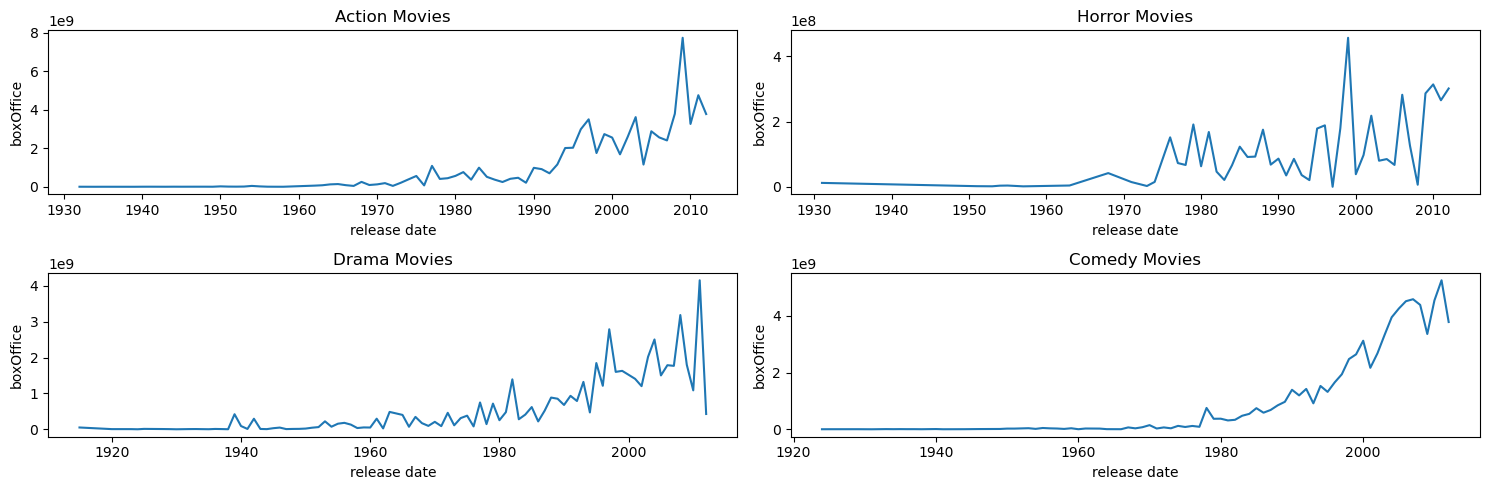

In [220]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))
box_df = {"Action": pd.DataFrame(), "Horror": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}

# draw the average of boxOffice by year for each cluster of each movie genre
for index, genre in enumerate(cluster_analysis_dataloader.keys()):
    box_df[genre] = cluster_analysis_dataloader[genre].copy()

    # transform the release date into year date
    box_df[genre]['release date'] = pd.to_datetime(box_df[genre]['release date'])
    box_df[genre]['release date'] = box_df[genre]['release date'].dt.year
    box_df[genre].dropna(subset=['release date'],  inplace=True)
    
    # Compute the average of boxOffice by year and by cluster
    sum_box = box_df[genre][['release date', 'boxOffice']].copy().groupby(['release date']).sum()
    sum_box.reset_index(inplace=True)
    sns.lineplot(x="release date", y="boxOffice", data=sum_box, palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")

fig.tight_layout()

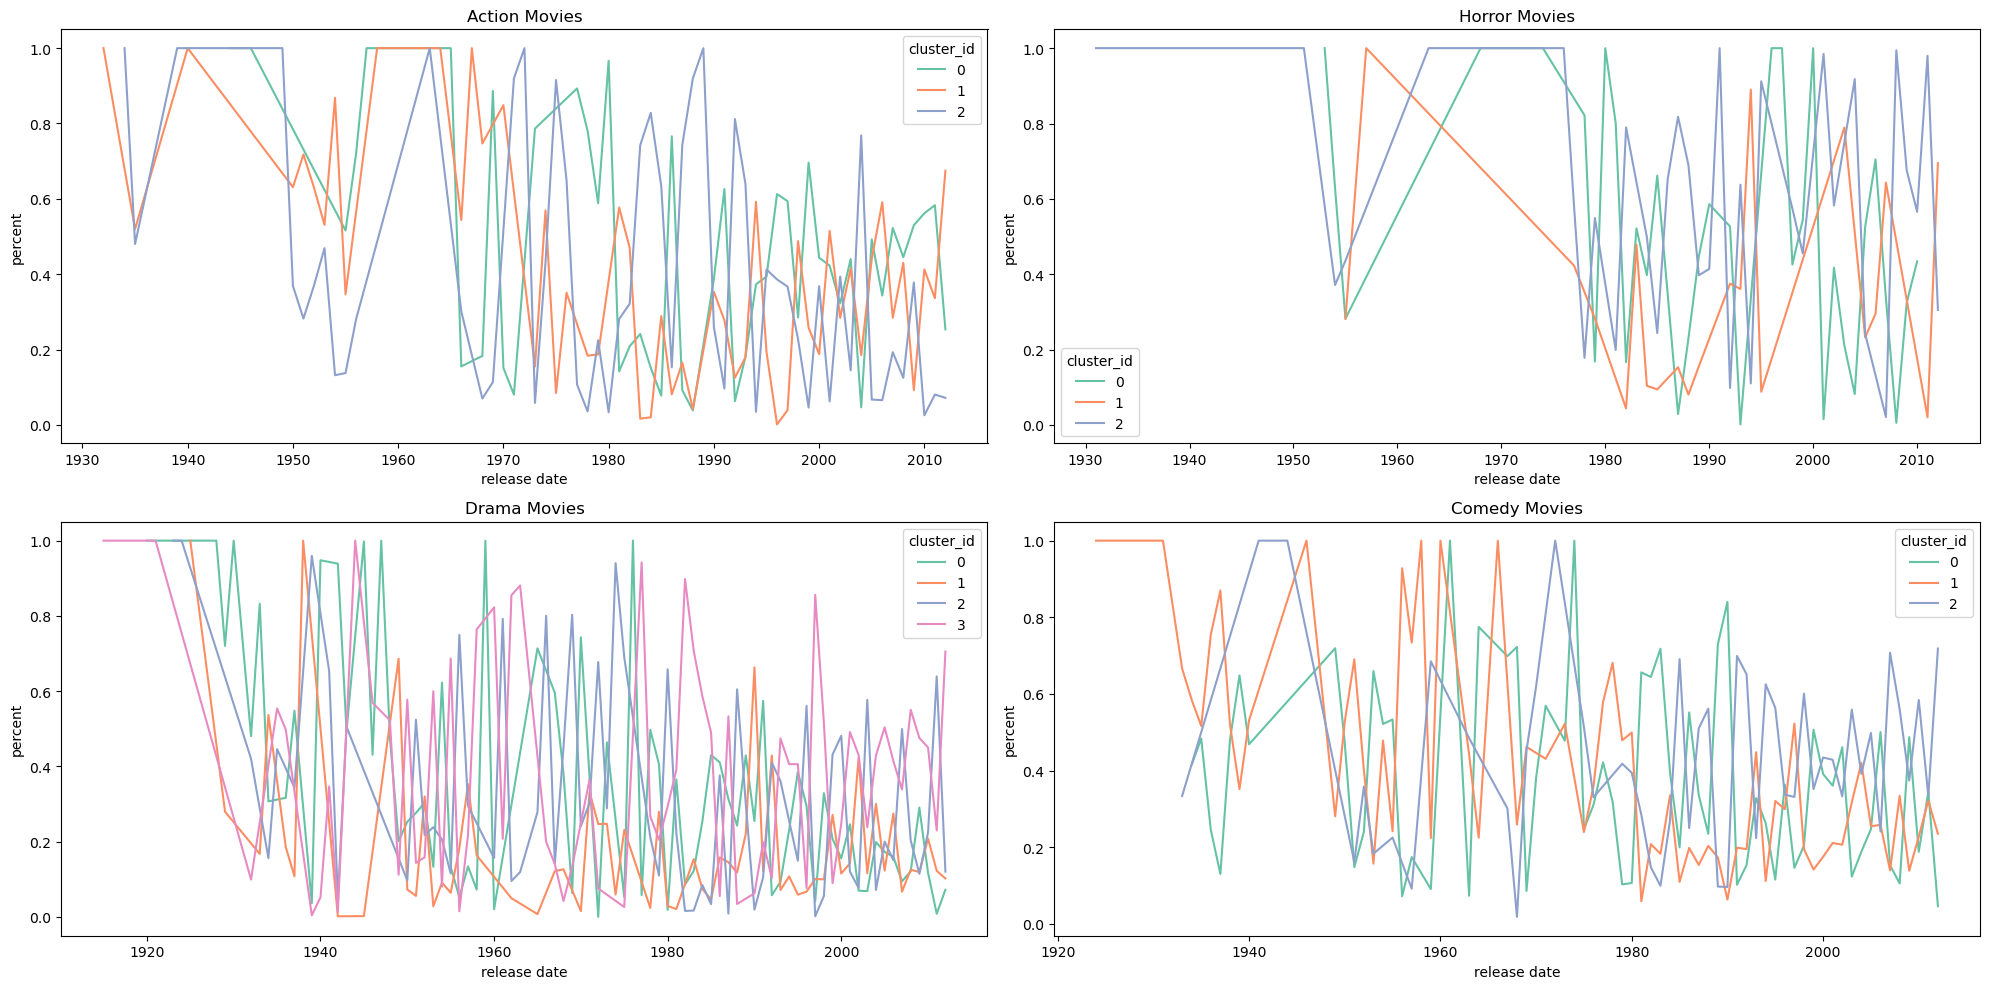

In [221]:
fig, axs = plt.subplots(2,2, figsize=(20, 10))
percent_box_df = box_df.copy()
# draw the average of boxOffice by year for each cluster of each movie genre
for index, genre in enumerate(cluster_analysis_dataloader.keys()):
    percent_box_df[genre]['percent'] = percent_box_df[genre][['release date', 'boxOffice']].groupby('release date').transform(lambda x : x/x.sum())['boxOffice']
    sum_percent_box_df = percent_box_df[genre][['release date', 'cluster_id', 'percent']].copy().groupby(['release date', 'cluster_id']).sum()
    sum_percent_box_df.reset_index(inplace=True)
    sns.lineplot(x="release date", y="percent", hue="cluster_id", data=sum_percent_box_df, palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")

fig.tight_layout()

In [236]:
quartile_df = box_df.copy()
for genre in quartile_df.keys():
    quartile_df[genre]["quartile"] = pd.qcut(quartile_df[genre]["release date"], q = 4, labels=False)

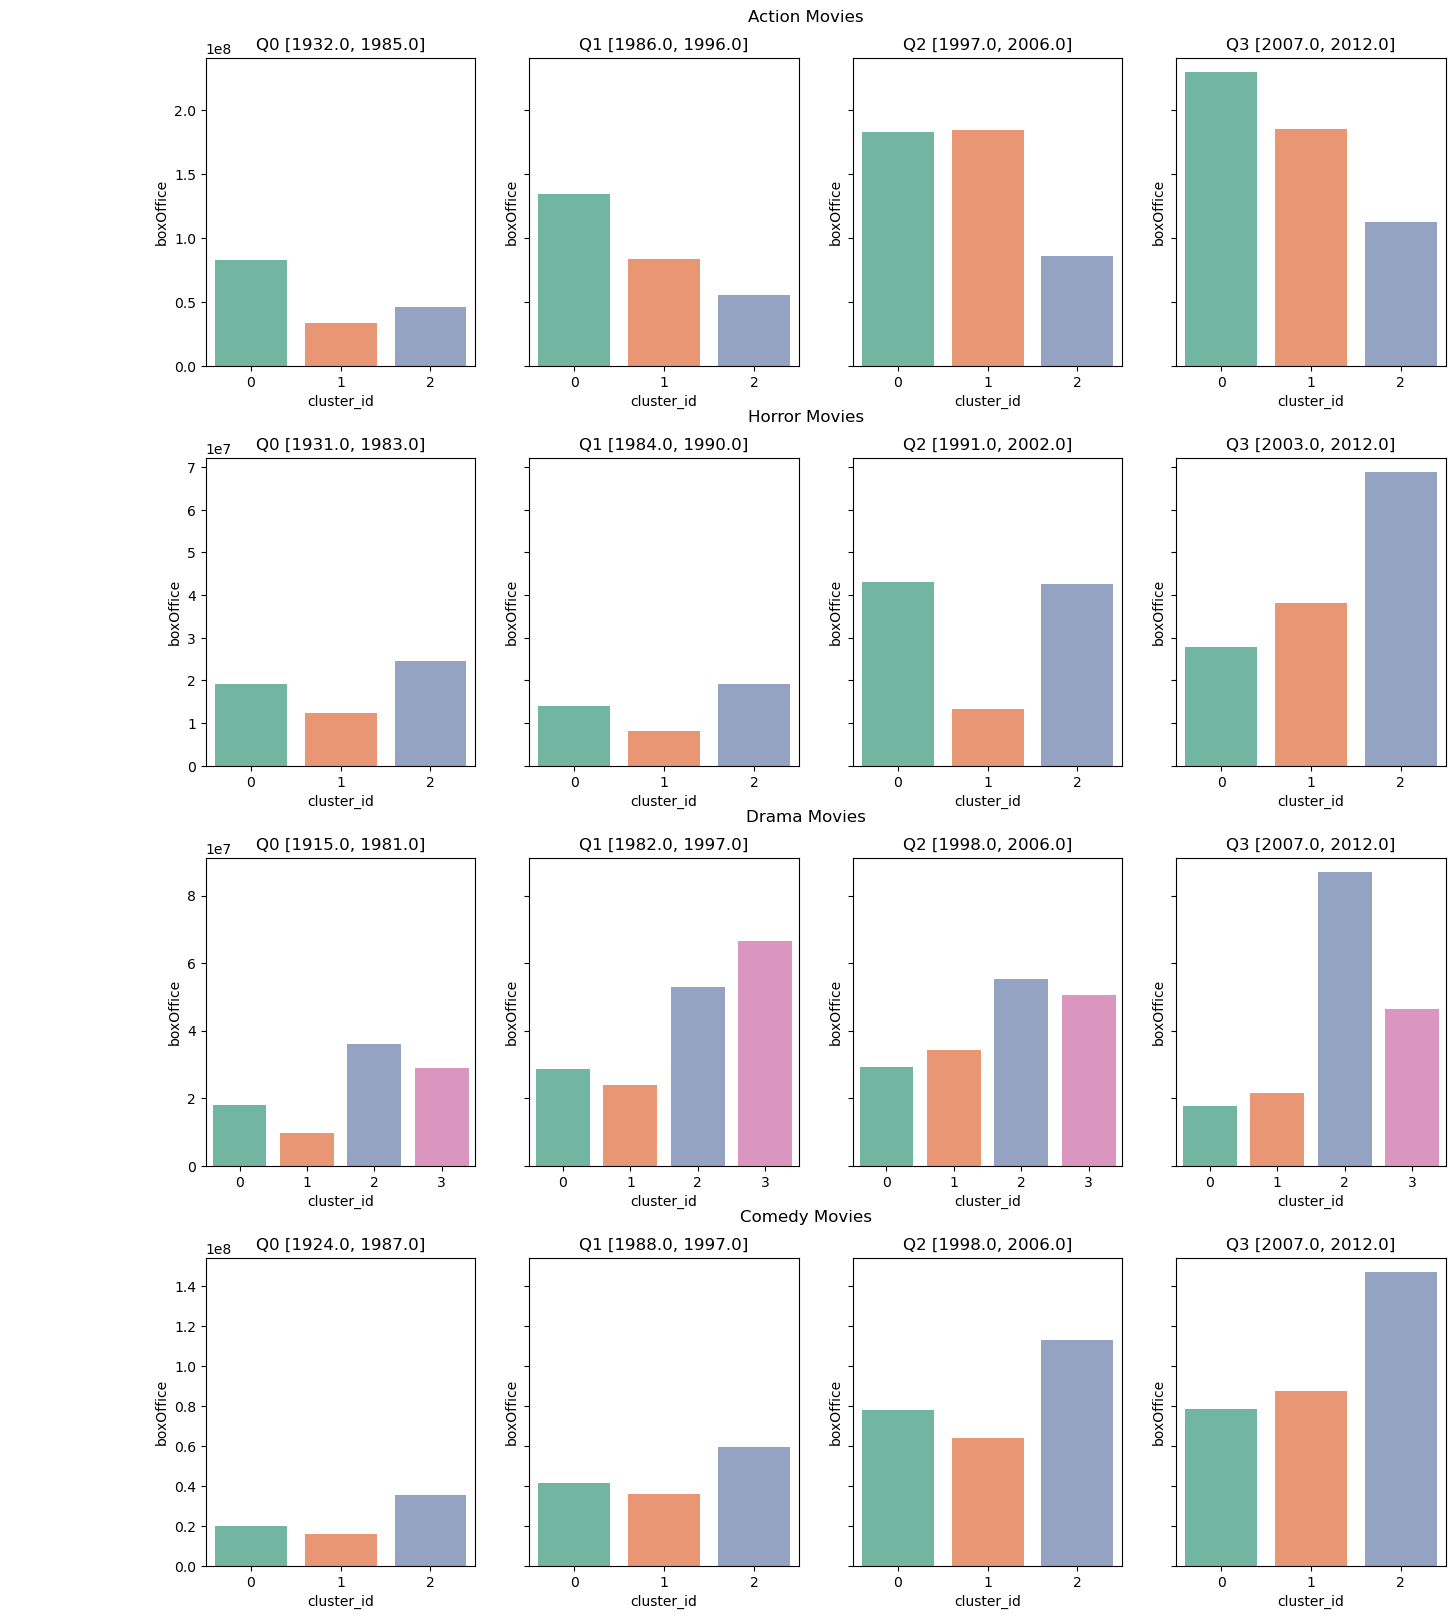

In [251]:
fig = plt.figure(figsize = (16,16), constrained_layout=True)
subfigs = fig.subfigures(nrows=4, ncols=1, hspace=10.0, wspace=0.07)
for genre, subfig in zip(quartile_df.keys(), subfigs):

    subfig.suptitle(f"{genre} Movies", y = 1.0)
    axs = subfig.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
    for i in range(best_ks[genre]):
        for q in range(4) :
            q_df = quartile_df[genre][quartile_df[genre]["quartile"] == q][['cluster_id', 'boxOffice', 'release date']].copy()
            minYear = q_df['release date'].min()
            maxYear = q_df['release date'].max()

            mean_boxOffice_cluster = q_df[['cluster_id', 'boxOffice']].groupby('cluster_id').mean()
            mean_boxOffice_cluster.reset_index(inplace=True)
            sns.barplot(x="cluster_id", y="boxOffice", data=mean_boxOffice_cluster, ax=axs[q], palette="Set2")
            axs[q].set_title(f"Q{q} [{minYear}, {maxYear}]")

        
fig.supxlabel('Cluster')
fig.supylabel('Box Office')
fig.subplots_adjust(hspace=10.5)

In [242]:
def print_metrics(genre) : 
    print(f"{genre} movies : ")
    for q in range(4):
        print(f"quartile{q} : ")
        samples = []
        for i in range(best_ks[genre]):
            box_offices = quartile_df[genre][(quartile_df[genre]["cluster_id"] == i) & (quartile_df[genre]["quartile"] == q)]["boxOffice"]
            samples.append(box_offices)
            ci,mean = bootstrap_CI(box_offices, nbr_of_samples)
            print(f"for cluster{i} the confidence interval is : {ci}")
        pvalue = stats.f_oneway(*samples).pvalue
        print(f"The pvalue for the clusters is {pvalue}")

In [243]:
print_metrics("Action")

Action movies : 
quartile0 : 
for cluster0 the confidence interval is : [39974493.51578947, 137521256.91578948]
for cluster1 the confidence interval is : [19570171.14473684, 50669527.58508772]
for cluster2 the confidence interval is : [26306042.14264706, 69970538.72720587]
The pvalue for the clusters is 0.07166526133647563
quartile1 : 
for cluster0 the confidence interval is : [83239541.73194446, 195876873.19027779]
for cluster1 the confidence interval is : [49596499.24032258, 123046555.25967741]
for cluster2 the confidence interval is : [38305268.07970589, 74267344.19588235]
The pvalue for the clusters is 0.0035913932186743204
quartile2 : 
for cluster0 the confidence interval is : [132269112.0795082, 240018773.02909836]
for cluster1 the confidence interval is : [123597208.88944444, 253812959.62222221]
for cluster2 the confidence interval is : [57697481.50454546, 116708354.12575758]
The pvalue for the clusters is 0.005460485776521815
quartile3 : 
for cluster0 the confidence interval is

In [244]:
print_metrics("Horror")

Horror movies : 
quartile0 : 
for cluster0 the confidence interval is : [11591062.060526317, 27779510.013157893]
for cluster1 the confidence interval is : [1972267.0, 25993692.59062499]
for cluster2 the confidence interval is : [11409252.604411766, 40301147.125]
The pvalue for the clusters is 0.5109259537306328
quartile1 : 
for cluster0 the confidence interval is : [9377808.877631579, 18704842.177631576]
for cluster1 the confidence interval is : [4498916.0, 11750622.714285715]
for cluster2 the confidence interval is : [12641401.6525, 26112258.5825]
The pvalue for the clusters is 0.1379436648562218
quartile2 : 
for cluster0 the confidence interval is : [14430480.271875, 81723037.44375]
for cluster1 the confidence interval is : [5141596.833333333, 21685732.5]
for cluster2 the confidence interval is : [24556102.465277776, 64665549.29305555]
The pvalue for the clusters is 0.47194407727782106
quartile3 : 
for cluster0 the confidence interval is : [11663652.792105265, 46427053.93815788]
for 

In [245]:
print_metrics("Drama")

Drama movies : 
quartile0 : 
for cluster0 the confidence interval is : [10321061.032708332, 26781356.989791665]
for cluster1 the confidence interval is : [5698664.935, 14888893.888999995]
for cluster2 the confidence interval is : [22215053.185064934, 52349634.5724026]
for cluster3 the confidence interval is : [15906549.2421875, 44965618.65124999]
The pvalue for the clusters is 0.012921153148926006
quartile1 : 
for cluster0 the confidence interval is : [19535691.084274195, 39485962.769354835]
for cluster1 the confidence interval is : [14022816.310588237, 37311697.65294115]
for cluster2 the confidence interval is : [32964244.278125, 75063950.90625]
for cluster3 the confidence interval is : [31806493.722772278, 119591518.10173255]
The pvalue for the clusters is 0.09197586754291395
quartile2 : 
for cluster0 the confidence interval is : [20032630.395430107, 39266908.83225806]
for cluster1 the confidence interval is : [21025021.760054346, 51823937.80298913]
for cluster2 the confidence interv

In [246]:
print_metrics("Comedy")

Comedy movies : 
quartile0 : 
for cluster0 the confidence interval is : [15535593.526984127, 25205623.291071426]
for cluster1 the confidence interval is : [10492556.485416666, 24269457.52520833]
for cluster2 the confidence interval is : [23396295.583333332, 51692895.63508772]
The pvalue for the clusters is 0.008200704864312357
quartile1 : 
for cluster0 the confidence interval is : [27371664.304950494, 57471468.11113861]
for cluster1 the confidence interval is : [24833297.869791664, 48910552.21041667]
for cluster2 the confidence interval is : [42687974.202393614, 78452234.11941488]
The pvalue for the clusters is 0.09220910272423508
quartile2 : 
for cluster0 the confidence interval is : [59749585.39979675, 97366993.44471544]
for cluster1 the confidence interval is : [44399680.09676724, 87652861.04116379]
for cluster2 the confidence interval is : [88462417.65601851, 140648428.18263888]
The pvalue for the clusters is 0.008603136793686446
quartile3 : 
for cluster0 the confidence interval is

#### Part 2.4: Most rated movie arc per genre (ratings)

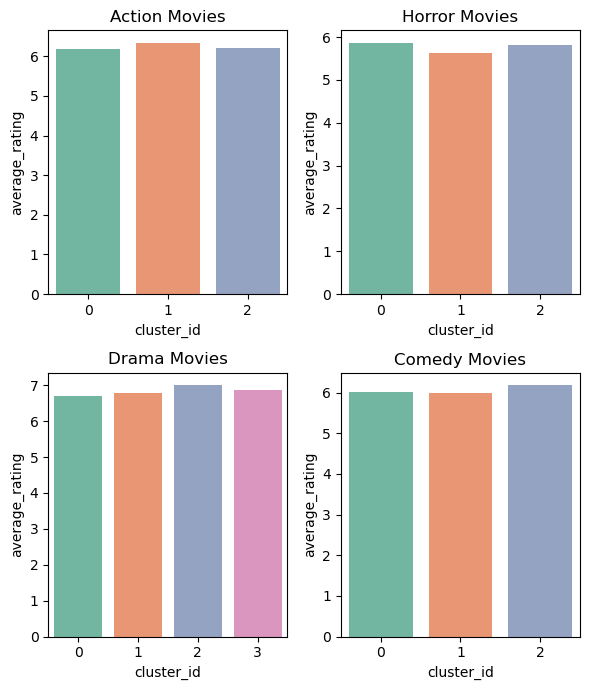

In [222]:
ratings_cluster_df = {"Action": pd.DataFrame(), "Horror": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}
fig, axs = plt.subplots(2,2, figsize=(6, 7))

#Compute the average rating for each cluster of each movie genre
for index, dataset in enumerate(cluster_analysis_dataloader.keys()):
    ratings_cluster_df[dataset] = grouped.merge(cluster_analysis_dataloader[dataset], left_on = 'originalTitle', right_on = 'Title')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    ratings_cluster_df[dataset] = ratings_cluster_df[dataset][ratings_cluster_df[dataset]['sum_of_vote'] >= 100][['cluster_id', 'average_rating']]
    mean_ratings_cluster = ratings_cluster_df[dataset].copy().groupby('cluster_id').mean()
    mean_ratings_cluster.reset_index(inplace=True)
    sns.barplot(x="cluster_id", y="average_rating", data=mean_ratings_cluster, ax=axs[int(index/2),index%2], palette="Set2")
    axs[int(index/2),index%2].set_title(dataset + " Movies")

fig.tight_layout()


Now we can observe the average of the ratings for each movie arc cluster. In Milestone 3, we analyze the displayed plots and perform significance tests to rank the different movie arc clusters present.

In [233]:
for genre in ratings_cluster_df.keys():
    print(f"{genre} movies : ")
    samples = []
    for i in range(best_ks[genre]):
        average_ratings = ratings_cluster_df[genre][ratings_cluster_df[genre]["cluster_id"] == i]["average_rating"]
        samples.append(average_ratings)
        ci,mean = bootstrap_CI(average_ratings, nbr_of_samples)
        print(f"for cluster{i} the confidence interval is : {ci}")
    pvalue = stats.f_oneway(*samples).pvalue
    print(f"The pvalue for the clusters is {pvalue}")

Action movies : 
for cluster0 the confidence interval is : [6.024433463672473, 6.336535193623829]
for cluster1 the confidence interval is : [6.199033403194372, 6.4837375825936645]
for cluster2 the confidence interval is : [6.074886025868167, 6.330053434664044]
The pvalue for the clusters is 0.2752952846228583
Horror movies : 
for cluster0 the confidence interval is : [5.638061297934923, 6.08581393798184]
for cluster1 the confidence interval is : [5.297138839714952, 5.963400406472266]
for cluster2 the confidence interval is : [5.585959696619761, 6.050677193452807]
The pvalue for the clusters is 0.5437357938526821
Drama movies : 
for cluster0 the confidence interval is : [6.610467078810222, 6.768449287111519]
for cluster1 the confidence interval is : [6.697246736928991, 6.877162452892222]
for cluster2 the confidence interval is : [6.895578326463534, 7.096301989715399]
for cluster3 the confidence interval is : [6.774104106963854, 6.9337491075083495]
The pvalue for the clusters is 2.975341

# Rating over time

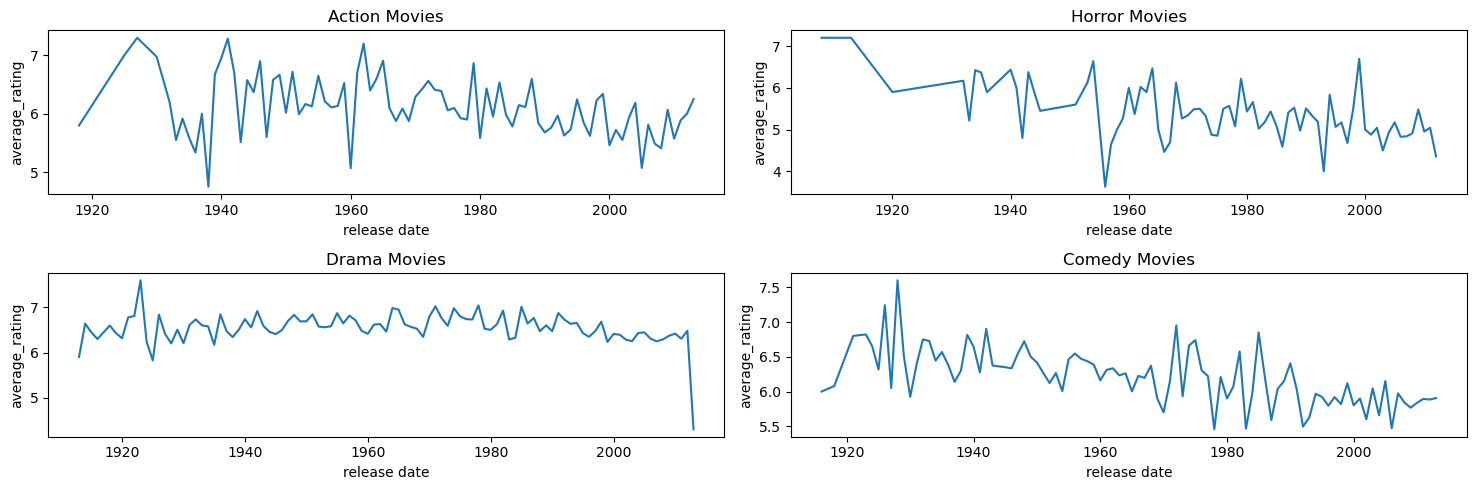

In [223]:
ratings_genre_over_time_df = {"Action": pd.DataFrame(), "Horror": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}
fig, axs = plt.subplots(2,2, figsize=(15, 5))

#Compute the average rating for each cluster of each movie genre
for index, genre in enumerate(dataset_by_genre.keys()):
    ratings_genre_over_time_df[genre] = grouped.merge(dataset_by_genre[genre], left_on = 'originalTitle', right_on = 'Title')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    ratings_genre_over_time_df[genre] = ratings_genre_over_time_df[genre][ratings_genre_over_time_df[genre]['sum_of_vote'] >= 100]
    # transform the release date into year date
    ratings_genre_over_time_df[genre]['release date'] = pd.to_datetime(ratings_genre_over_time_df[genre]['release date'])
    ratings_genre_over_time_df[genre]['release date'] = ratings_genre_over_time_df[genre]['release date'].dt.year
    ratings_genre_over_time_df[genre].dropna(subset=['release date'],  inplace=True)


    mean_ratings_cluster_over_time = ratings_genre_over_time_df[genre][['average_rating', 'release date']].copy().groupby(['release date']).mean()
    mean_ratings_cluster_over_time.reset_index(inplace=True)
    sns.lineplot(x="release date", y="average_rating", data=mean_ratings_cluster_over_time, palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")

fig.tight_layout()

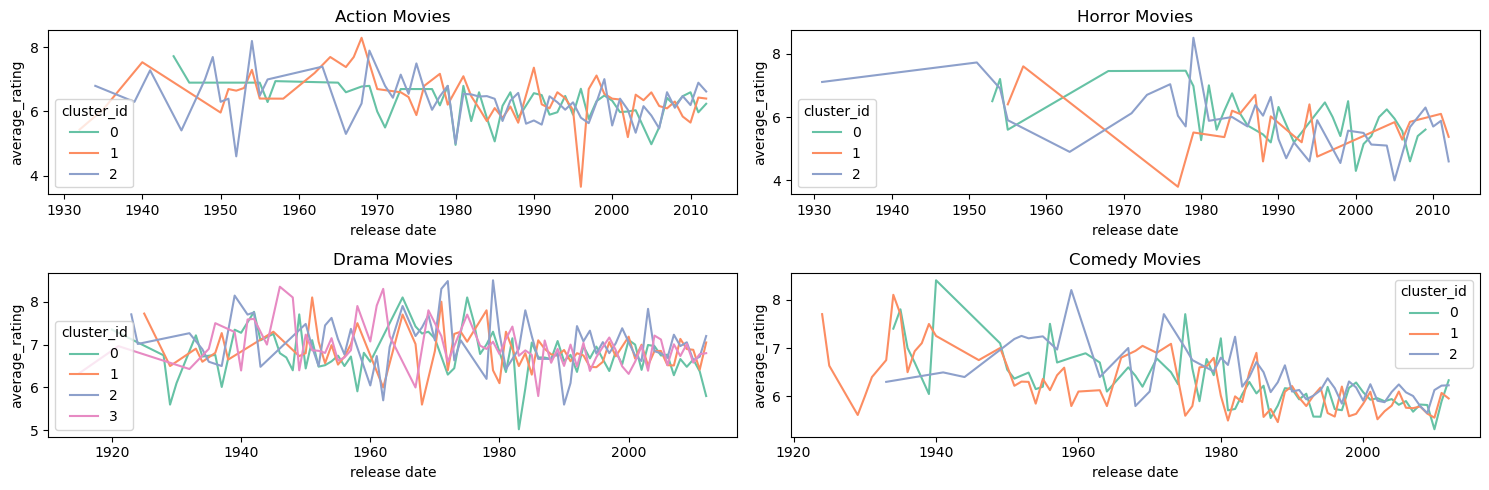

In [224]:
ratings_cluster_over_time_df = {"Action": pd.DataFrame(), "Horror": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}
fig, axs = plt.subplots(2,2, figsize=(15, 5))

#Compute the average rating for each cluster of each movie genre
for index, genre in enumerate(cluster_analysis_dataloader.keys()):
    ratings_cluster_over_time_df[genre] = grouped.merge(cluster_analysis_dataloader[genre], left_on = 'originalTitle', right_on = 'Title')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    ratings_cluster_over_time_df[genre] = ratings_cluster_over_time_df[genre][ratings_cluster_over_time_df[genre]['sum_of_vote'] >= 100]
    # transform the release date into year date
    ratings_cluster_over_time_df[genre]['release date'] = pd.to_datetime(ratings_cluster_over_time_df[genre]['release date'])
    ratings_cluster_over_time_df[genre]['release date'] = ratings_cluster_over_time_df[genre]['release date'].dt.year
    ratings_cluster_over_time_df[genre].dropna(subset=['release date'],  inplace=True)
    mean_ratings_cluster_over_time = ratings_cluster_over_time_df[genre][['cluster_id', 'average_rating', 'release date']].copy().groupby(['cluster_id', 'release date']).mean()
    mean_ratings_cluster_over_time.reset_index(inplace=True)
    sns.lineplot(x="release date", y="average_rating", hue='cluster_id', data=mean_ratings_cluster_over_time, palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")

fig.tight_layout()